# **Start**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title  { display-mode: "form" }
#@title  { display-mode: "form" }
#@title  { vertical-output: true, display-mode: "form" }
#@markdown Select The Best

use_pearson_corr = False #@param ["True", "False"]
Data_to_use = "6_bands" #@param ["6_bands", "65_bands", "372_bands", "Planet_hisar", "Pavia", "Indian_Pines", "Hisar_sentinel"]
use_pearson_corr = True if use_pearson_corr in [True, "True"] else False
method = " with_cls_tkn" #@param [" with_gap", " without_gap", " with_cls_tkn"]
P_S = "9"  #@param [3, 9, 15, 21]
P_S = int(P_S)
patch_size = 3
transformer_layers = 5  #@param [3,5,7,9,11]
projection_dim = 256    #@param [64, 128, 256, 512, 1024]
Targeted_accuracy = "0.985" #@param [0.97, 0.98, 0.985, 0.99, 0.995]
Min_trainable_epoch = 20 #@param [20, 25, 30, 35, 40, 50, 100]

train_percent = 75                  #@param [75, 80, 90]
epoch = "200" # @param ["100","200","300","400","500"]

LR_START = 3e-3
LR_MAX = 6e-3
LR_MIN = 1e-5

batch_size = 128
BATCH_SIZE = 128
dropout_rate_for_uncertainty = "0.25"    #@param [0.1, 0.2, 0.25, 0.3, 0.4, 0.5]
dropout = "0.1"                         #@param [0.1, 0.2, 0.25, 0.3, 0.4, 0.5]
num_patches = (P_S//patch_size)**2

epoch = int(epoch)
Min_trainable_epoch = int(Min_trainable_epoch)
Targeted_accuracy = float(Targeted_accuracy)
train_percent = int(train_percent)
dropout = float(dropout)
dropout_rate = float(dropout_rate_for_uncertainty)
shifts = int(1/dropout_rate)
assert epoch >= Min_trainable_epoch/dropout_rate, f"For Min_trainable_epoch: {Min_trainable_epoch} & dropout_rate: {dropout_rate}, minimum number of `epoch` should be {Min_trainable_epoch/dropout_rate}"
transformer_layers = int(transformer_layers)
projection_dim = int(projection_dim)

print("Number of patches per P_S: ", num_patches)
print("Size of each patch for Multihead Attention: ", patch_size)

Number of patches per P_S:  9
Size of each patch for Multihead Attention:  3


In [ ]:
!pip install spectral
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 8.9 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow_addons (from versions: none)
ERROR: No matching distribution found for tensorflow_addons


In [ ]:
import pandas as pd           # for csv files and dataframes
import numpy as np            # Linear Algebra tools
import matplotlib.pyplot as plt  # for ploting graphs and curve
from matplotlib import colors, cm, gridspec
import scipy.stats as st
import scipy.io as si         # for inputing matlab files
from random import shuffle    # for shuffling dataset
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix   #Confusion matrix creation
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report

import datetime
import time
import warnings
import math
import os
import gc

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.python.util.tf_export import keras_export
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Input, Add, Multiply, Reshape, Dense, Activation, BatchNormalization, Flatten, Dropout, concatenate, Lambda, LayerNormalization
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D,  GlobalAveragePooling2D, GlobalAvgPool2D, DepthwiseConv2D, SeparableConv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, add, multiply, MultiHeadAttention
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.utils import control_flow_util
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import glorot_uniform, Ones
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.regularizers import l2

import spectral

np.random.seed(1337)          # to get reproducible results
base_path = "/content/drive/MyDrive/m_p/Uncertainty in Models/Vision Transformers/ViT with U-Net architecture/"

try:
    os.mkdir(base_path)
except:
    pass

try:
    os.mkdir(base_path + "With Pearson correlation/") if use_pearson_corr else os.mkdir(base_path + "Without Pearson correlation/")
except:
    pass

if use_pearson_corr:
    folder_path = base_path + "With Pearson correlation/" + str(Data_to_use) + "/"
    try:
        os.mkdir(folder_path)
    except:
        pass
else:
    folder_path = base_path + "Without Pearson correlation/" + str(Data_to_use) + "/"
    try:
        os.mkdir(folder_path)
    except:
        pass

In [ ]:
try:
    os.mkdir(folder_path + "Trained models")
    os.mkdir(folder_path + "Results")
except:
    pass

In [ ]:
Normalize_data = True
if Data_to_use == "6_bands":
    H, W, B = 330, 307, 6
    x = np.array(pd.read_csv('/content/drive/My Drive/m_p/data/multispectral/data.csv'))
    y = np.array(pd.read_csv('/content/drive/My Drive/m_p/data/multispectral/ref.csv'))

if Data_to_use == "65_bands":
    H, W, B = 512, 512, 65
    x = si.loadmat('/content/drive/My Drive/m_p/data/Dias/DIAS.mat')['DIAS']
    y = si.loadmat('/content/drive/My Drive/m_p/data/Dias/DIAS_ref.mat')['DIAS_ref']

if Data_to_use == "372_bands":
    H, W, B = 1101, 566, 372
    x = si.loadmat('/content/drive/My Drive/m_p/data/372 band/full.mat')['full']
    y = si.loadmat('/content/drive/My Drive/m_p/data/372 band/full_gt.mat')['full_gt']
    x[x < 0.0] = 0.0
    x[x > 1.0] = 1.0
    Normalize_data = False
    #x = x[:, selective_bands]

if Data_to_use == "Planet_hisar":
    H, W, B = 1733, 2647, 4
    x = pd.read_csv('/content/drive/My Drive/m_p/data/planet_data_hisar/planet.csv', header=None)
    y = pd.read_csv('/content/drive/My Drive/m_p/data/planet_data_hisar/planetgt.csv', header=None)

if Data_to_use == "Pavia":
    H, W, B = 610, 340, 103
    x = si.loadmat('/content/drive/MyDrive/m_p/data/pavia/paviauni.mat')['paviaU']
    y = si.loadmat('/content/drive/MyDrive/m_p/data/pavia/paviauni_gt.mat')['paviaU_gt']

if Data_to_use == "Indian_Pines":
    H, W, B = 145, 145, 220
    x = si.loadmat('/content/drive/My Drive/m_p/data/Indian_pines/Indian_pines.mat')['indian_pines']
    y = si.loadmat('/content/drive/My Drive/m_p/data/Indian_pines/Indian_pines_gt.mat')['indian_pines_gt']

if Data_to_use == "Hisar_sentinel":
    H, W, B = 722, 1014, 4
    x = np.array(si.loadmat('/content/drive/My Drive/m_p/data/Hissar_25%/datas.mat')['datas'])
    y = np.array(pd.read_csv('/content/drive/My Drive/m_p/data/Hissar_25%/fullgt.csv'))

y_shape = np.array(y).shape[0]
x, y = np.array(x).reshape(H,W,B), np.array(y).reshape(H,W)
x = x.astype('float16')
#########
print("minimum value in raw data is :", x.min())
print("maximum value in raw data is :", x.max(), "\n")
print("shape of raw data: ", x.shape)
print("shape of target data: ", y.shape, "\n")

# Normalizing the data between 0,1
if Normalize_data:
    for i in range(B):
        band_min = x[:,:,i].min()
        band_max = x[:,:,i].max()
        band_range = band_max - band_min
        x[:,:,i] = (x[:,:,i] - band_min)/band_range

minimum value in raw data is : 12.0
maximum value in raw data is : 209.0 

shape of raw data:  (330, 307, 6)
shape of target data:  (330, 307) 



# **Data**

In [ ]:
pad_width = int((P_S-1)/2)
padded_x = np.pad(x,[(pad_width,pad_width),(pad_width,pad_width),(0,0)],'edge')
# np.save("/content/drive/MyDrive/Personal Folder for training/padded_x.npy" , padded_x)
X,Y = [],[]
for a in range(H):
  for b in range(W):
    if(y[a][b]!= 0):
      patch = padded_x[a:a+P_S,b:b+P_S,:]
      X.append(patch)
      Y.append(y[a][b]-1)

num_classes = len(np.unique(y))-1
Approximate_rgb_img = x[:,:,[B//2-1, B//2, B//2+1]]*255

print()
print("minimum value in x is :", x.min())
print("maximum value in x is :", x.max())
print()
print("shape of x: ", x.shape)
print("shape of y: ", y.shape)
print()
print("shape of padded_x: ", padded_x.shape, "\n")
print(f"{len(Y)*100/y_shape:.4f}% of data is labeled with {num_classes} classes")


minimum value in x is : 0.0
maximum value in x is : 1.0

shape of x:  (330, 307, 6)
shape of y:  (330, 307)

shape of padded_x:  (338, 315, 6) 

17.0161% of data is labeled with 7 classes


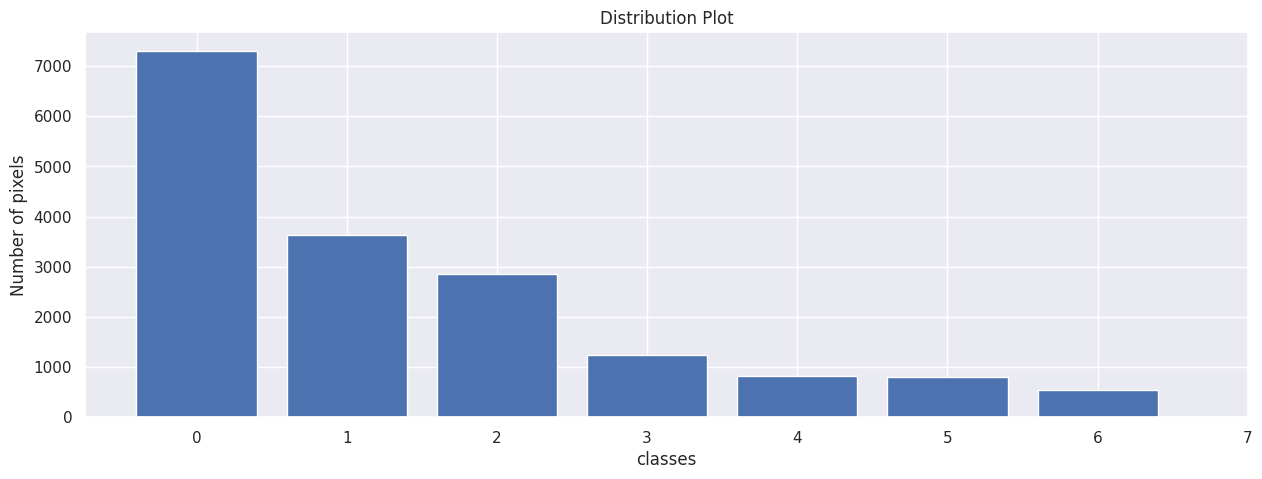

In [ ]:
class_labels, value_counts = np.unique(y.reshape(-1,1), return_counts = True)
plt.figure(figsize = (15,5))
plt.bar(class_labels[1:]-1, value_counts[1:])
plt.xticks(class_labels, rotation = 0)
plt.xlabel("classes")
plt.ylabel("Number of pixels")
plt.title("Distribution Plot")
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=(train_percent/100),stratify=Y, random_state=10)
x_train,x_test,y_train,y_test = np.array(x_train),np.array(x_test),np.array(y_train),np.array(y_test)
print(f"x_train: {x_train.shape} \nx_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}")

x_train: (12929, 9, 9, 6) 
x_test: (4310, 9, 9, 6) 
y_train: (12929,) 
y_test: (4310,)


# **Functions**

In [ ]:
def predict_half_image_prob(model, padded_x, H, W_range, B, P_S):
    y_prob = np.zeros((H, W_range, num_classes))
    for j in range(W_range):
        patchs = np.zeros((H, P_S, P_S, B))
        for i in range(H):
            patchs[i,:,:,:] = padded_x[i:i+P_S, j:j+P_S, :]
        y_pred_prob = model.predict(patchs, verbose = -1)
        y_prob[:,j,:] = y_pred_prob
        del patchs, y_pred_prob
        gc.collect()
    return y_prob

def probabilistic_outputs(model, padded_x, H, W, B, P_S):
    start_time = time.time()
    half_1 = padded_x.shape[1]//2 + pad_width+1
    half_2 = padded_x.shape[1]//2 - pad_width-1
    padded_x_1st_half = padded_x[:,:half_1, :]
    padded_x_2nd_half = padded_x[:,half_2:, :]
    del padded_x
    gc.collect()

    y_hat = np.zeros((H,W, num_classes))
    y_hat[:,:W//2,:] = predict_half_image_prob(model, padded_x_1st_half, H, W//2, B, P_S)
    print("image predicted ███████████████████████ 50%")
    gc.collect()
    width = W//2 if W//2 == W/2 else W//2+1
    y_hat[:,W//2:,:] = predict_half_image_prob(model, padded_x_2nd_half, H, width, B, P_S)
    print("image predicted ██████████████████████████████████████████████ 100%")
    gc.collect()
    end_time = time.time()
    time_taken = end_time - start_time
    time_min = time_taken//60
    time_sec = time_taken - time_min*60
    print(f'total time taken is: {time_min} min {time_sec:.2f} sec.')
    print("shape of predicted image is: ", y_hat.shape)
    return y_hat

In [ ]:
def predict(model, x_test):
    y_pred = np.argmax(model.predict(x_test, verbose = -1), axis = -1)
    return y_pred

In [ ]:
def plot_accuracy_loss_curve(history, use_pearson_corr = None, folder_path = None):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize = (24,8))
    ax = plt.subplot(1,1,1)
    ax2 = ax.twinx()
    ax.plot(train_accuracy, color='blue', marker='o', linewidth=1.5, markersize = 2,  label = 'train_accuracy')
    ax.plot(val_accuracy, color='green', marker='o', linewidth=1.5, markersize = 2, label = 'val_accuracy')
    ax.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('accuracy')
    ax.legend()
    ax2.plot(train_loss, color = 'black', marker='o', linewidth=1.5, markersize = 2, label = 'train_loss')
    ax2.plot(val_loss, color = 'red', marker='o', linewidth=1.5, markersize = 2, label = 'val_loss')
    ax2.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('loss')
    plt.title('accuracy and loss plot for model performance')
    ax2.legend()
    plt.show()
    if folder_path:
        if use_pearson_corr:
            path = folder_path + "Results/Pearson_Corr " + str(train_percent) + "% ps_"+ str(P_S) + " accuracy_loss.png"
        else:
            path = folder_path + "Results/" + str(train_percent) + "% ps_"+ str(P_S) + " accuracy_loss.png"
        fig.savefig(path)

In [ ]:
def performance_meausures(y_test, y_pred, tt, *parameters_summary, folder_path = None):
    Total_params, Trainable_params, Non_trainable_params = parameters_summary
    accuracy = accuracy_score(y_test, y_pred)
    kappa=cohen_kappa_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred).astype('int32')
    cr = classification_report(y_test, y_pred, output_dict=True)
    df_cr = pd.DataFrame(cr).T
    df_score = pd.DataFrame({'accuracy score: ' : [accuracy], 'Cohen_Kappa score: ' : [kappa], "Training Time: " : [tt]}).T
    df_summary = pd.DataFrame({'Total_params: ': [Total_params], 'Trainable_params: ' : [Trainable_params], 'Non_trainable_params: ':[Non_trainable_params]}).T

    spec = gridspec.GridSpec(ncols = 2, nrows = 2, width_ratios=[1,3], wspace = 0.5, hspace = 0.5, height_ratios=[7,1])

    fig = plt.figure(figsize = (24,10))

    ax1 = fig.add_subplot(spec[0])
    ax1.set_title('classification report')
    sns.heatmap(df_cr, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax1)

    ax2 = fig.add_subplot(spec[1])
    ax2.set_title('confusion matrix')
    ax2.set_xlabel('predicted class')
    ax2.set_ylabel('actual class')
    sns.heatmap(cm, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax2)

    ax3 = fig.add_subplot(spec[2])
    sns.heatmap(df_score, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax3)
    ax3.set_xticks([])

    ax4 = fig.add_subplot(spec[3])
    sns.heatmap(df_summary, cmap = "Blues", cbar = False, annot = True, fmt=' .10g', ax = ax4)
    ax4.set_xticks([])

    if folder_path:
        path = folder_path + "Results/" + str(train_percent) + "% ps_" + str(P_S) +" Performance Measure.png"
        fig.savefig(path)

In [ ]:
def measure_uncertainty(model, x_test, y_test):
    y_prob = model.predict(x_test, verbose = -1)

    """Sorting is as follow
    y_prob = [[11 12 13 22]
              [31 10 33  7]
              [21  7 23 14]]

    temp_prob will sort the y_prob along rows
    temp_prob = [[11 12 13 22]
                 [7  10 31 33]
                 [7  14 21 23]]

    Now sort the y_prob based on the last column of temp_pred i.e. last col is [22, 33, 23] and sorting will be [22, 23, 33] ---> [0, 2, 1]
     y_prob = [[11 12 13 22]
               [21  7 23 14]
               [31 10 33  7]]
    """
    temp_pred = np.sort(y_prob, axis = -1)      # sort the probabilities along rows. Higher prob values are along last column
    y_prob = y_prob[temp_pred[:,-1].argsort()]  # Arange the rows of predicted prob in assending position

    num = y_prob.shape[0]
    # observed = y_prob.max(axis = -1)
    observed = np.sort(y_prob, axis = -1)[:,-1]    # class predicted according to 1st maximum prob
    observed_1 = np.sort(y_prob, axis = -1)[:,-2]  # class predicted according to 2nd maximum prob
    observed_2 = np.sort(y_prob, axis = -1)[:,-3]  # class predicted according to 3rd maximum prob

    mean = y_prob.mean(axis = -1)
    std = y_prob.std(axis = -1)
    plt.figure(figsize = (24,8))
    plt.plot(np.arange(1, num+1, 1), observed - observed_1, color = "black", label = "certaintity")
    plt.plot(np.arange(1, num+1, 1), observed, color = "blue", label = "observed")
    plt.plot(np.arange(1, num+1, 1), observed_1, color = "purple", label = "observed_1")
    plt.plot(np.arange(1, num+1, 1), observed_2, color = "cyan", label = "observed_2")
    plt.plot(np.arange(1, num+1, 1), mean, color = "red", label = "mean")
    plt.plot(np.arange(1, num+1, 1), mean + 2*std, color = "green", label = "mean + 2*std")
    plt.plot(np.arange(1, num+1, 1), mean - 2*std, color = "green", label = "mean - 2*std")
    plt.legend()
    plt.title("Predictions based on normal model")
    plt.show()

In [ ]:
class Pearson_correlation_masked(layers.Layer):
    def __init__(self, P_S = 9, **kwargs):
        super(Pearson_correlation_masked, self).__init__(**kwargs)
        self.P_S = P_S

    def call(self, inputs):
        self.loc = (self.P_S)//2
        self.inputs = inputs
        self.channels = self.inputs.shape[-1]
        self.x_mean = tf.repeat(tf.math.reduce_mean(self.inputs, axis = -1, keepdims=True), repeats = self.channels, axis = -1)

        self.y = tf.repeat(tf.repeat(self.inputs[:,self.loc:self.loc+1, self.loc:self.loc+1, :], repeats = self.P_S, axis = -2), repeats = self.P_S, axis = -3)

        self.y_mean = tf.repeat(tf.math.reduce_mean(self.y, axis = -1, keepdims = True), repeats = self.channels, axis = -1)

        self.a = tf.math.subtract(self.inputs, self.x_mean)
        self.b = tf.math.subtract(self.y, self.y_mean)
        self.ab = tf.math.multiply(self.a,self.b)
        self.num = tf.math.reduce_sum(self.ab, axis = -1, keepdims = True)

        self.a_new = tf.math.reduce_sum(tf.math.multiply(self.a, self.a), axis = -1, keepdims = True)
        self.b_new = tf.math.reduce_sum(tf.math.multiply(self.b, self.b), axis = -1, keepdims = True)
        self.deno = tf.math.sqrt(tf.math.multiply(self.a_new, self.b_new))

        self.corr = tf.math.divide(self.num, self.deno)

        self.thresh = tf.math.reduce_mean(self.corr)
        self.mask = self.corr > self.thresh
        self.mask = tf.cast(self.mask, self.corr.dtype)

        self.masked_corr = tf.math.multiply(self.mask, self.corr)

        self.attention_weights = tf.repeat(self.masked_corr, repeats = self.channels, axis = -1)
        return multiply([self.inputs, self.attention_weights])

    def get_config(self, **kwargs):
        config = super(Pearson_correlation_masked, self).get_config()
        config.update({
            "P_S": self.P_S,
        })
        return config

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class Dropout_Train(layers.Layer):
    def __init__(self, rate, shift=1, **kwargs):
        super().__init__(**kwargs)
        self.rate = rate
        self.shift = shift

    def call(self, inputs, training=None):
        if self.rate == 0:
            return inputs

        def dropped_inputs():
            input_dim = tf.shape(inputs)[-1]

            range_0 = tf.cast(self.rate * (self.shift - 1) * tf.cast(input_dim, tf.float32), tf.int32)
            range_1 = tf.cast(self.rate * self.shift * tf.cast(input_dim, tf.float32), tf.int32)

            # Build mask dynamically
            mask = tf.concat([
                tf.ones([range_0], dtype=inputs.dtype),
                tf.zeros([range_1 - range_0], dtype=inputs.dtype),
                tf.ones([input_dim - range_1], dtype=inputs.dtype)
            ], axis=0)

            # Reshape mask: broadcast to [batch, seq_len, channels]
            mask = tf.reshape(mask, [1, 1, input_dim])
            return inputs * mask

        return tf.__internal__.smart_cond.smart_cond(
            training,
            true_fn=dropped_inputs,
            false_fn=lambda: tf.identity(inputs),
        )

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
def modified_model(model, layer_name, rate, new_layer, shift, **kwargs):
    name = kwargs.get("name", None)

    x = model.layers[0].output
    modification = False
    z = 0

    for lyr in model.layers[1:]:
        lyr_name = lyr.name.upper()
        target = layer_name.upper()

        if target in lyr_name:
            # When shift is int
            if not isinstance(shift, str):
                x = new_layer(rate=rate, shift=shift, name=f"{layer_name}_{shift}_{z}")(x)
            else:
                # When shift is str
                x = new_layer(rate=rate, name=f"{layer_name}_{shift}_{z}")(x)
            modification = True
            z += 1
        else:
            x = lyr(x)

    if not modification:
        print("⚠️ Warning: No layer was modified. Check if layer_name matches actual model.layer names!")

    return Model(inputs=model.inputs, outputs=x, name=name)

In [ ]:
from tensorflow.keras.callbacks import Callback

class CustomCallbacks(Callback):
    def __init__(self, filepath, epochs, rate,
                 new_layer=Dropout_Train,
                 layer_name="DROPOUT",
                 accuracy_score=0.99,
                 min_epochs=50):
        super().__init__()
        self.filepath = filepath
        self.epochs = epochs
        self.new_layer = new_layer
        self.rate = rate
        self.best = 0.0
        self.epoch_num = 1
        self.layer_name = layer_name
        self.min_epochs = min_epochs
        self.accuracy_score = accuracy_score if accuracy_score <= 1.0 else accuracy_score / 100.0

    def on_train_begin(self, logs=None):
        self.shift = 1
        self.epoch_completed = 0
        print(f"Model will be trained in {int(1/self.rate)} shifts")
        print("Starting training with 1st shift\n")
        self.model = modified_model(self.model, self.layer_name, self.rate, self.new_layer, self.shift)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = None
        # make it robust across tf/keras metric names
        for k, v in logs.items():
            if "val" in k and "acc" in k:
                val_acc = v
                break

        self.epoch_completed += 1
        self.epoch_num += 1

        if val_acc and val_acc >= self.accuracy_score and self.epoch_completed >= self.min_epochs:
            if self.shift < int(1 / self.rate):
                print(f"\nTargeted accuracy reached. Completing shift {self.shift}/{int(1/self.rate)}")
                self.shift += 1
                self.model = modified_model(self.model, self.layer_name, self.rate, self.new_layer, self.shift)
                self.epoch_completed = 0
            elif self.shift == int(1 / self.rate):
                print("\nAll shifting done. Rebuilding final model...")
                self.model = modified_model(self.model, self.layer_name, self.rate, self.new_layer, "Final", name="ResNet")
                self.shift += 1
                self.epoch_completed = 0

        if self.shift >= int(1 / self.rate):
            if val_acc is not None and val_acc > self.best and (self.epoch_num >= self.epochs - 10):
                print(f"val_accuracy improved from {self.best:.4f} to {val_acc:.4f}")
                self.best = val_acc
                self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        if self.shift <= int(1 / self.rate):
            raise RuntimeError(f"Training incomplete: only {self.shift-1} shifts done (expected {int(1/self.rate)})")

        print(f"Training completed in {self.shift-1} shifts.")
        self.model.set_weights(self.best_weights)
        print(f"Saving best model to {self.filepath}")
        self.model.save(self.filepath)

In [ ]:
class SpectralAttention(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.pool = layers.GlobalAveragePooling2D(keepdims=True)
        self.conv1 = layers.Conv2D(filters, kernel_size=1, activation="relu")
        self.conv2 = layers.Conv2D(filters, kernel_size=1, activation="sigmoid")

    def call(self, inputs):
        x = self.pool(inputs)          # [B, 1, 1, C]
        x = self.conv1(x)              # [B, 1, 1, C]
        x = self.conv2(x)              # [B, 1, 1, C]
        return x

    def get_config(self):
        config = super().get_config()
        config.update({"filters": self.filters})
        return config

In [ ]:
class SpatialAttention(layers.Layer):
    def __init__(self, k_size=3, **kwargs):
        super().__init__(**kwargs)
        self.k_size = k_size
        self.norm = layers.BatchNormalization()
        self.conv1 = layers.Conv2D(1, kernel_size=(k_size, k_size), padding="same")
        self.conv2 = layers.Conv2D(1, kernel_size=(k_size, k_size), padding="same")
        self.conv3 = layers.Conv2D(1, kernel_size=(k_size, k_size), padding="same")
        self.conv4 = layers.Conv2D(1, kernel_size=(k_size, k_size), padding="same")
        self.act_relu = layers.Activation("relu")
        self.act_sigmoid = layers.Activation("sigmoid")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.norm(x)
        x = self.conv2(x)
        x = self.act_relu(x)
        x = self.conv3(x)
        x = self.act_relu(x)
        x = self.conv4(x)
        return self.act_sigmoid(x)

    def get_config(self):
        config = super().get_config()
        config.update({"k_size": self.k_size})
        return config

In [ ]:
class SpatialAttention1(layers.Layer):
    def __init__(self, input_shape, **kwargs):
        super().__init__(**kwargs)
        self.input_shape_val = input_shape
        self.filters = input_shape[-1]
        self.k_size = input_shape[1]

        self.norm = layers.BatchNormalization()
        self.conv1 = layers.Conv2D(self.filters, kernel_size=3, padding="same", kernel_initializer="he_normal")
        self.conv2 = layers.Conv2D(self.filters, kernel_size=3, strides=2, padding="same")
        self.conv3 = layers.Conv2D(self.filters, kernel_size=3, strides=2, padding="same")

        self.convt1 = layers.Conv2DTranspose(self.filters, kernel_size=3, strides=2, padding="same")
        self.convt2 = layers.Conv2DTranspose(self.filters, kernel_size=3, strides=2, padding="same")

        self.relu = layers.ReLU()
        self.sigmoid = layers.Activation("sigmoid")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.norm(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.relu(x)

        x = self.convt1(x)
        x = self.relu(x)

        x = self.convt2(x)
        x = self.relu(x)

        # shape correction if needed
        if x.shape[1] != self.input_shape_val[1] or x.shape[2] != self.input_shape_val[2]:
            k_size = x.shape[1] - self.k_size + 1
            x = layers.Conv2D(self.filters, kernel_size=k_size, strides=1, padding="valid")(x)

        return self.sigmoid(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "input_shape": self.input_shape_val,
            "filters": self.filters,
            "k_size": self.k_size
        })
        return config

In [ ]:
# Implement Feed Forward Network / MLP
def MLP(x, hidden_units, dropout_rate):
    """
    Feedforward network used inside Transformer blocks.
    hidden_units: list of layer sizes (e.g. [mlp_dim, embed_dim])
    dropout_rate: dropout between dense layers
    """
    for units in hidden_units:
        # Use GELU activation, which is common in ViTs
        x = layers.Dense(units, activation=tf.keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Implement patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size, embed_dim=768, **kwargs):
        super(Patches, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.embed_dim = embed_dim

    def build(self, input_shape):
        # Flatten each patch across spatial + spectral channels, then project
        _, H, W, C = input_shape
        patch_dim = self.patch_size * self.patch_size * C
        self.projection = layers.Dense(self.embed_dim)

    def call(self, images):
        batch_size = tf.shape(images)[0]

        # Extract non-overlapping patches
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]   # = patch_size*patch_size*C
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])

        # Project raw patches to embedding dimension for the transformer
        return self.projection(patches)

    def get_config(self):
        config = super(Patches, self).get_config()
        config.update({
            "patch_size": self.patch_size,
            "embed_dim": self.embed_dim,
        })
        return config

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim

        # Linear projection of patches → projection_dim
        self.projection = layers.Dense(units=projection_dim)

        # Position embedding (num_patches + 1 to include CLS token)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches + 1, output_dim=projection_dim
        )

        # Learnable class token
        cls_init = tf.zeros_initializer()
        self.cls_token = self.add_weight(
            name="cls_token",
            shape=(1, 1, projection_dim),
            initializer=cls_init,
            trainable=True,
        )

    def call(self, patch, **kwargs):
        batch_size = tf.shape(patch)[0]

        # Project patches [B, num_patches, projection_dim]
        patch_proj = self.projection(patch)

        # Broadcast cls token for this batch [B, 1, projection_dim]
        cls_tokens = tf.repeat(self.cls_token, repeats=batch_size, axis=0)

        # Concatenate CLS + patch sequence
        x = tf.concat([cls_tokens, patch_proj], axis=1)

        # Add position embeddings
        positions = tf.range(start=0, limit=self.num_patches + 1, delta=1)
        pos_embeddings = self.position_embedding(positions)
        encoded = x + pos_embeddings

        return encoded

    def get_config(self):
        config = super(PatchEncoder, self).get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection_dim,
        })
        return config

In [ ]:
class Weighted_add(layers.Layer):
    def __init__(self, name, **kwargs):
        super(Weighted_add, self).__init__(**kwargs)
        self.wt_name = name

    def build(self, input_shape):
        # Use add_weight instead of raw tf.Variable
        self.w = self.add_weight(
            name="weighted_add_" + str(self.wt_name),
            shape=(1,),
            initializer=tf.random_normal_initializer(),
            trainable=True
        )

    def call(self, input_1, input_2):
        return input_1 * self.w + input_2 * (1.0 - self.w)

    def get_config(self):
        config = super(Weighted_add, self).get_config()
        config.update({
            "wt_name": self.wt_name,
        })
        return config

In [ ]:
# def TransFormer(input, num_head, projection_dim, dropout, **kwargs):
#     # x1 = LayerNormalization(epsilon=1e-6)(input)
#     attention_output = MultiHeadAttention(num_heads = num_head, key_dim = projection_dim, dropout = dropout)(input, input)
#     x2 = Add()([attention_output, input])
#     x3 = LayerNormalization(epsilon=1e-6)(x2)
#     # x3 = self.drop2(self.dense2(self.drop1(self.dense1(x3))))
#     x3 = MLP(x3, hidden_units=[projection_dim*2, projection_dim], dropout_rate=dropout)
#     # print(x2.shape, x3.shape)
#     out = Add()([x3, x2])
#     return out

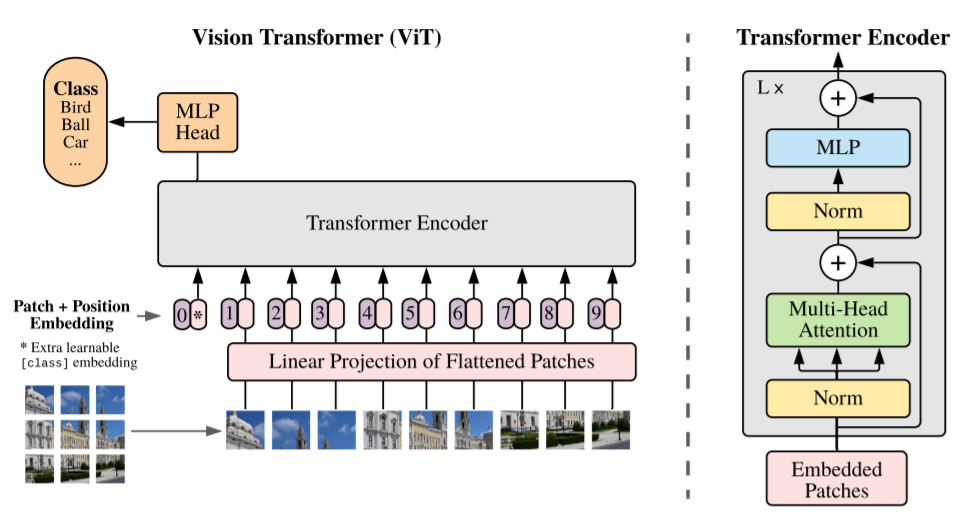

In [ ]:
class TransFormer(layers.Layer):
    def __init__(self, layer_num, num_heads, projection_dim, dropout=0.1, **kwargs):
        super(TransFormer, self).__init__(**kwargs)
        self.layer_num = layer_num
        self.num_heads = num_heads
        self.projection_dim = projection_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.norm1 = layers.LayerNormalization(epsilon=1e-6, name=f"ln1_{self.layer_num}")
        self.norm2 = layers.LayerNormalization(epsilon=1e-6, name=f"ln2_{self.layer_num}")

        self.add1 = Weighted_add(f"transformer_1_{self.layer_num}")
        self.add2 = Weighted_add(f"transformer_2_{self.layer_num}")

        self.mha = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.projection_dim,
            dropout=self.dropout,
            name=f"mha_{self.layer_num}"
        )

        self.dense1 = layers.Dense(self.projection_dim * 2, activation=tf.keras.activations.gelu)
        self.drop1 = layers.Dropout(self.dropout)

        self.dense2 = layers.Dense(self.projection_dim, activation=tf.keras.activations.gelu)
        self.drop2 = layers.Dropout(self.dropout)

    def call(self, inputs, training=None):
        # Multi-Head Attention block
        x1 = self.norm1(inputs)
        x1 = self.mha(x1, x1, training=training)
        x1 = self.add1(x1, inputs)   # residual with learned weighting

        # Feed Forward block
        x2 = self.norm2(x1)
        x2 = self.dense1(x2)
        x2 = self.drop1(x2, training=training)
        x2 = self.dense2(x2)
        x2 = self.drop2(x2, training=training)

        return self.add2(x2, x1)     # residual with learned weighting

    def get_config(self):
        config = super(TransFormer, self).get_config()
        config.update({
            "layer_num": self.layer_num,
            "num_heads": self.num_heads,
            "projection_dim": self.projection_dim,
            "dropout": self.dropout
        })
        return config

In [ ]:
class TransFormer_Block(layers.Layer):
    def __init__(self, num_layers, num_heads, projection_dim, dropout=0.1, **kwargs):
        super(TransFormer_Block, self).__init__(**kwargs)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.projection_dim = projection_dim
        self.dropout = dropout

    def build(self, input_shape):
        # Build list of TransFormer layers
        self.Blocks = [
            TransFormer(i, self.num_heads, self.projection_dim, self.dropout)
            for i in range(self.num_layers)
        ]

    def call(self, inputs, training=None):
        block_list = []
        x = inputs
        for i in range(self.num_layers):
            if i <= self.num_layers // 2:
                x = self.Blocks[i](x, training=training)
                block_list.append(x)
            else:
                x = self.Blocks[i](x, training=training)
                # Symmetric skip connection (mirror like U‑Net)
                x = layers.Add()([x, block_list[self.num_layers - i - 1]])
        return x

    def get_config(self):
        config = super(TransFormer_Block, self).get_config()
        config.update({
            "num_layers": self.num_layers,
            "num_heads": self.num_heads,
            "projection_dim": self.projection_dim,
            "dropout": self.dropout,
        })
        return config

In [ ]:
class Class_Token_Norm(layers.Layer):
    def __init__(self, eps=1e-6, **kwargs):
        super(Class_Token_Norm, self).__init__(**kwargs)
        self.eps = eps
        self.norm = layers.LayerNormalization(epsilon=self.eps)

    def call(self, inputs):
        # Normalize entire sequence, then extract CLS token
        x = self.norm(inputs)
        cls_token = x[:, 0, :]     # shape (B, D)
        return cls_token

    def get_config(self):
        config = super(Class_Token_Norm, self).get_config()
        config.update({
            "eps": self.eps
        })
        return config

In [ ]:
projection_dim = 256
num_heads = 4
transformer_layers = 12
dropout = 0.1          # dropout inside Transformer blocks

def create_vit_classifier(input_shape=(P_S, P_S, B),
                          num_classes=7,
                          use_pearson_corr=False,
                          dropout_rate=0.25,
                          method="with_gap",
                          k_heads: int = 1):
    """
    Vision Transformer classifier with optional multi-head outputs.
    - k_heads: number of classification heads (each head = independent Dense softmax).
      If k_heads == 1 -> returns a single logits tensor (shape [B, num_classes]).
      If k_heads > 1 -> returns a list of k_heads tensors [ (B,num_classes), ... ].
    """
    inputs = layers.Input(shape=input_shape)

    # Optional Pearson correlation preprocessing
    if use_pearson_corr:
        x0 = Pearson_correlation_masked(P_S)(inputs)
    else:
        x0 = inputs

    # Patch creation
    patches = Patches(patch_size, embed_dim=projection_dim)(x0)

    # Patch encoding
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer stack
    encoded_patches = TransFormer_Block(transformer_layers, num_heads, projection_dim, dropout)(encoded_patches)
    encoded_patches = layers.Dropout(dropout_rate, name="TRAIN_DROPOUT_1")(encoded_patches)

    # Representation strategies
    if method == "with_cls_tkn":
        # normalize + extract CLS token
        representation = Class_Token_Norm(eps=1e-6)(encoded_patches)
    elif method == "without_gap":
        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = layers.Flatten()(representation)
    elif method == "with_gap":
        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = tf.reduce_mean(representation, axis=1)  # [B, D]
    else:
        raise ValueError(f"Unknown method: {method}")

    # Classification head (shared backbone -> separate heads)
    x = layers.Dense(512, activation=tf.keras.activations.gelu)(representation)
    x = layers.Dropout(dropout_rate, name="TRAIN_DROPOUT_3")(x)
    x = layers.Dense(256, activation=tf.keras.activations.gelu)(x)
    x = layers.Dense(128, activation=tf.keras.activations.gelu)(x)
    x = layers.Dropout(dropout_rate, name="TRAIN_DROPOUT_5")(x)
    x = layers.Dense(64, activation=tf.keras.activations.gelu)(x)
    features = layers.Dropout(dropout_rate, name="TRAIN_DROPOUT_6")(x)

    # Build k_heads softmax outputs
    output_heads = []
    for i in range(max(1, k_heads)):
        head_name = f"head_{i+1}"
        head_logits = layers.Dense(num_classes, activation="softmax", dtype="float32", name=head_name)(features)
        output_heads.append(head_logits)

    # Return single tensor if only 1 head (backwards compatibility)
    if k_heads == 1:
        model = keras.Model(inputs=inputs, outputs=output_heads[0])
    else:
        model = keras.Model(inputs=inputs, outputs=output_heads)

    return model


In [ ]:
K_HEADS = 7   # same as your ViT
model = create_vit_classifier(
    input_shape=(P_S, P_S, B),
    num_classes=num_classes,
    use_pearson_corr=use_pearson_corr,
    dropout_rate=dropout_rate,
    method="with_cls_tkn",
    k_heads=K_HEADS
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9, 9, 6)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 256) │     14,080 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 10, 256)   │     68,608 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trans_former__block │ (None, 10, 256)   │ 15,790,104 │ patch_encoder[0]… │
│ (TransFormer_Block) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TRAIN_DROPOUT_1     │ (None, 10, 256)   │          0 │ trans_former__bl… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class__token__norm  │ (None, 256)       │        512 │ TRAIN_DROPOUT_1[… │
│ (Class_Token_Norm)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 512)       │    131,584 │ class__token__no… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TRAIN_DROPOUT_3     │ (None, 512)       │          0 │ dense_26[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 256)       │    131,328 │ TRAIN_DROPOUT_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 128)       │     32,896 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TRAIN_DROPOUT_5     │ (None, 128)       │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 64)        │      8,256 │ TRAIN_DROPOUT_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TRAIN_DROPOUT_6     │ (None, 64)        │          0 │ dense_29[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_1 (Dense)      │ (None, 7)         │        455 │ TRAIN_DROPOUT_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_2 (Dense)      │ (None, 7)         │        455 │ TRAIN_DROPOUT_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_3 (Dense)      │ (None, 7)         │        455 │ TRAIN_DROPOUT_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_4 (Dense)      │ (None, 7)         │        455 │ TRAIN_DROPOUT_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_5 (Dense)      │ (None, 7)         │        455 │ TRAIN_DROPOUT_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_6 (Dense)      │ (None, 7)         │        455 │ TRAIN_DROPOUT_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_7 (Dense)      │ (None, 7)         │        455 │ TRAIN_DROPOUT_6[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,180,553 (61.72 MB)

 Trainable params: 16,180,553 (61.72 MB)

 Non-trainable params: 0 (0.00 B)

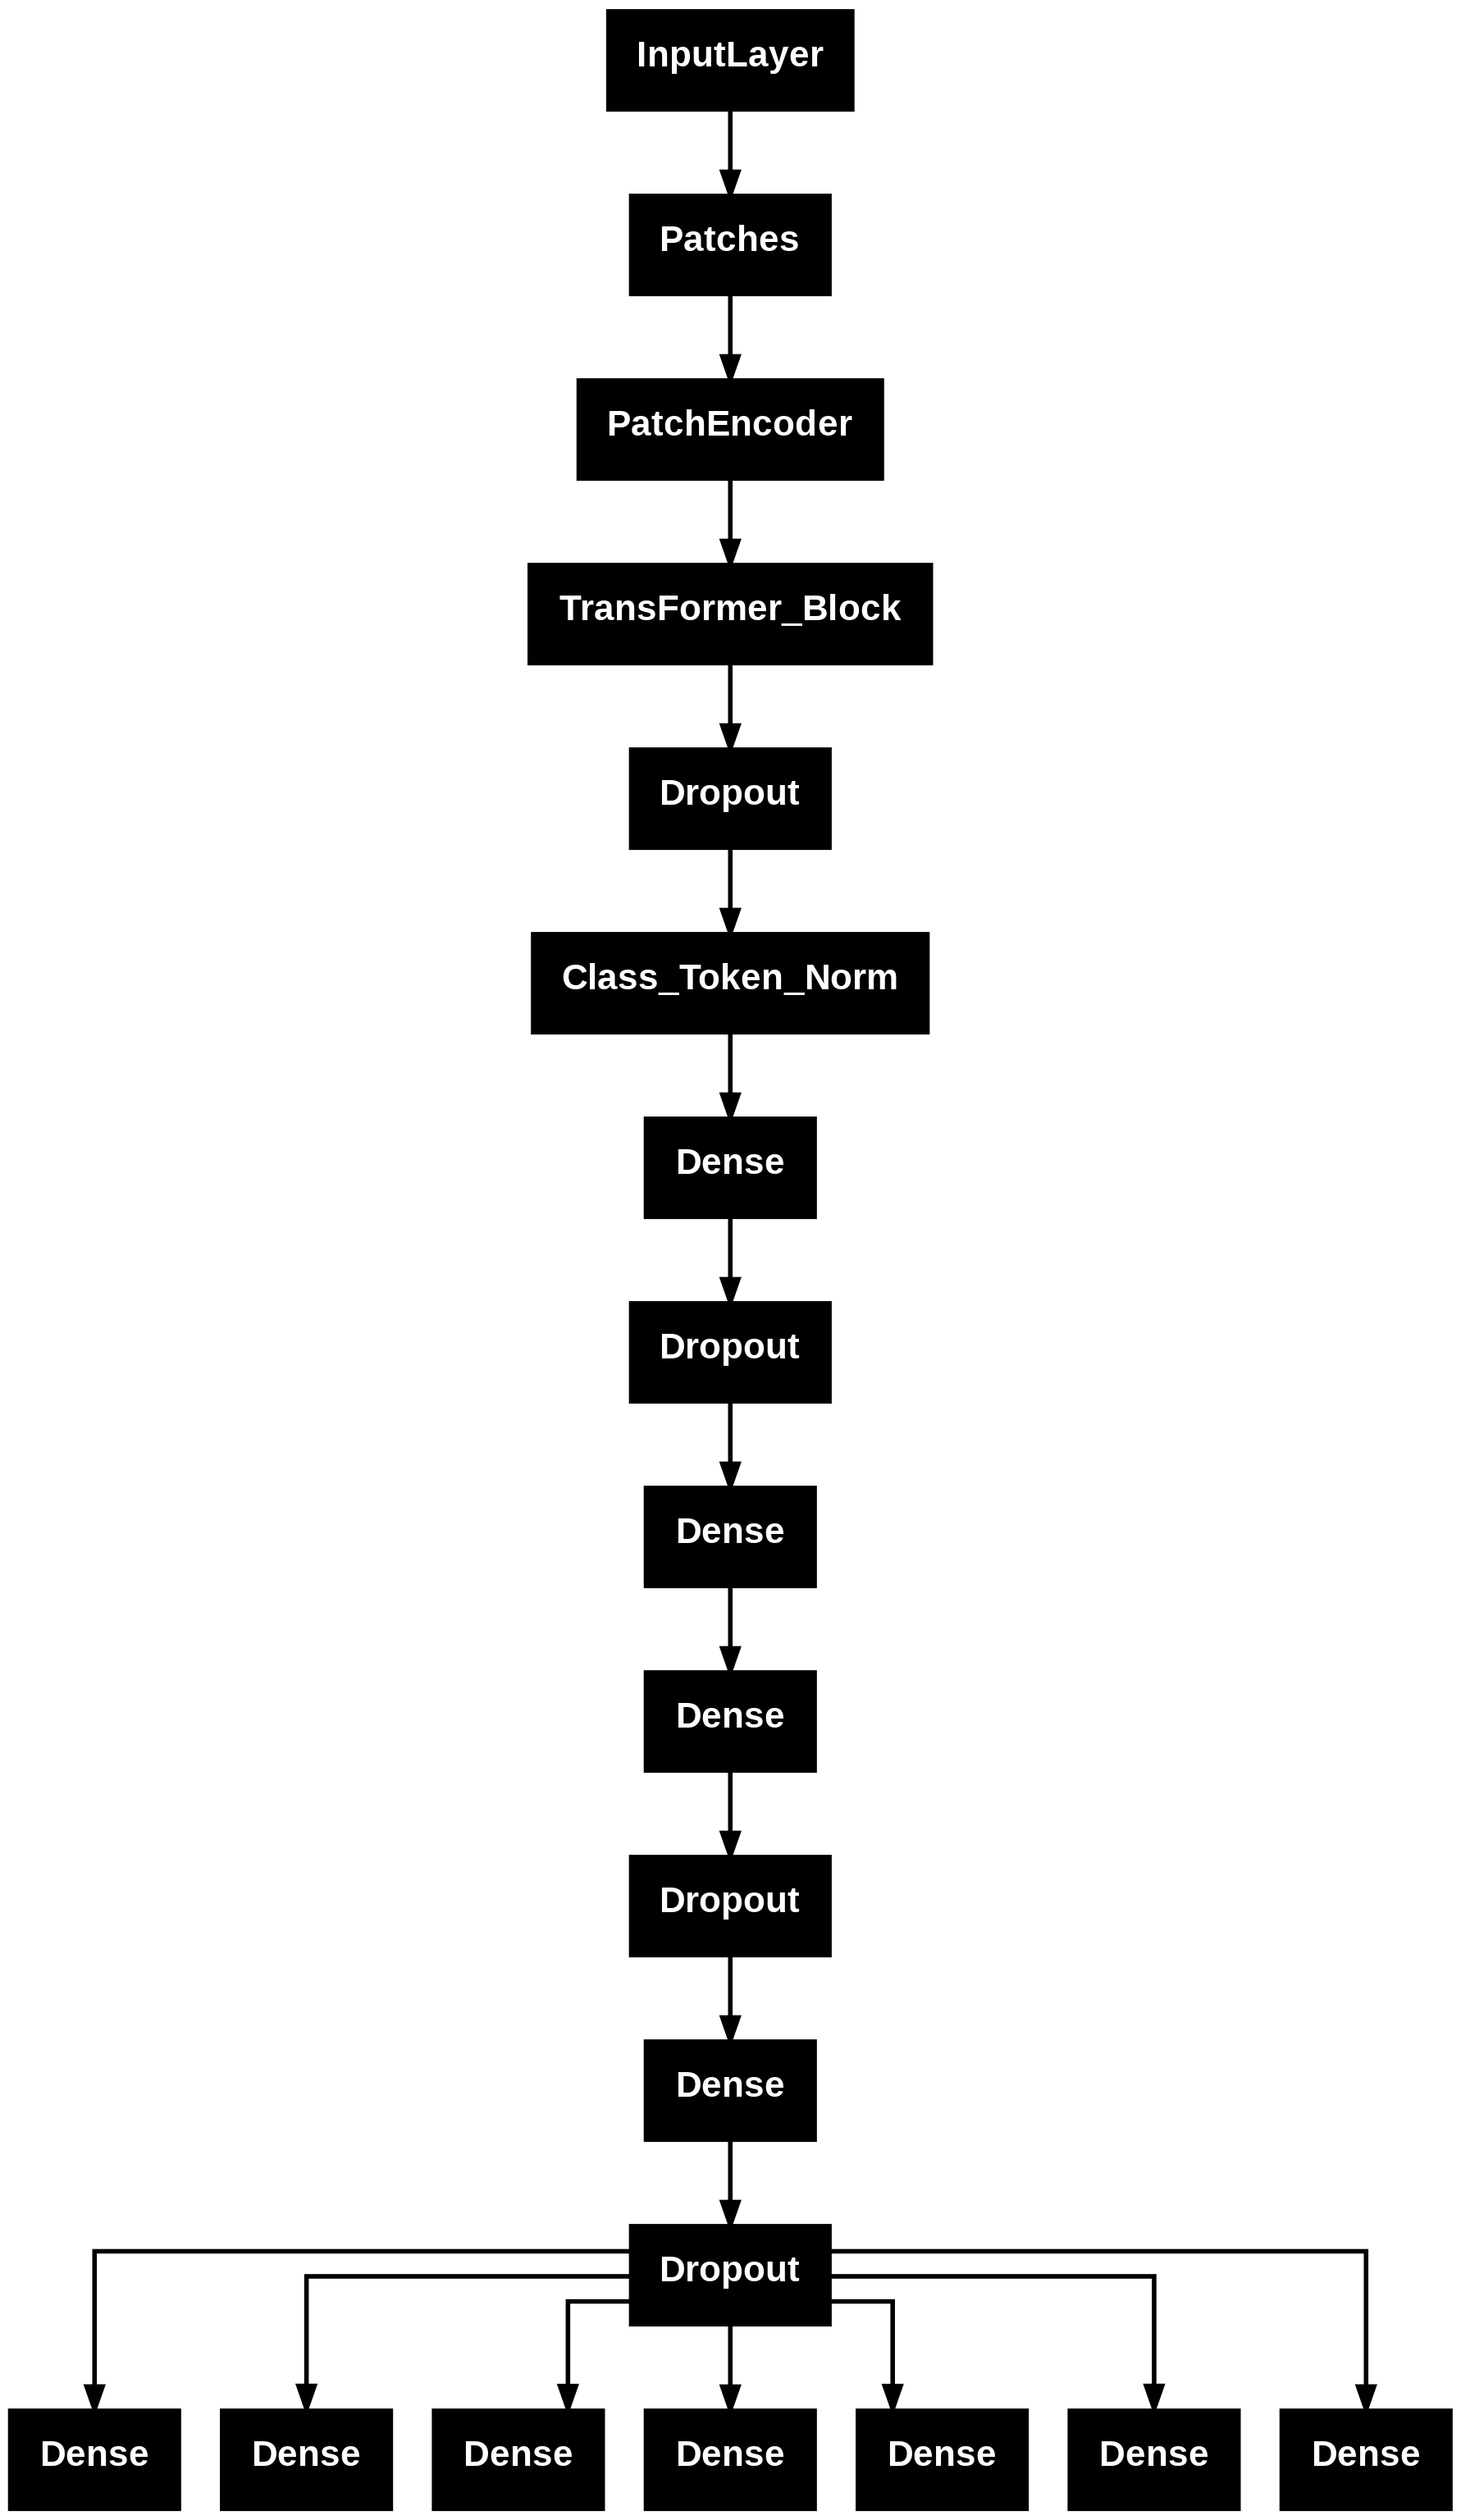

In [ ]:
# plot model architecture
plot_model(model,to_file = folder_path + "model_architecture.png", show_shapes=False)

# **Training**

Learning rate schedule: 0.0006 to 0.0006 to 1e-07


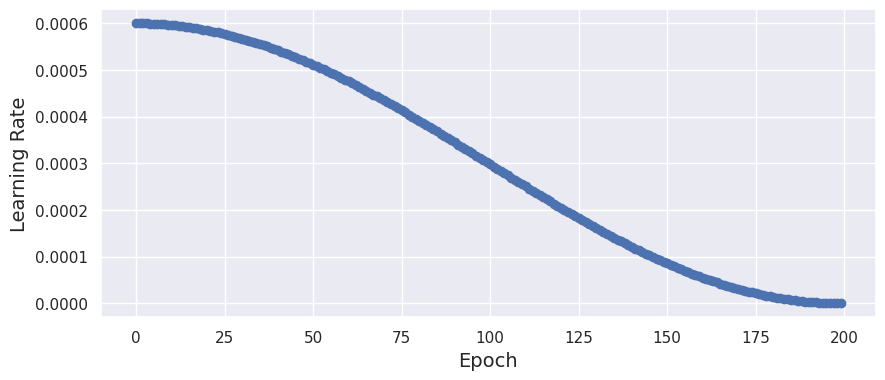

In [ ]:
LR_START = 3e-4
LR_MAX = 6e-4
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = epoch

def lrfn(epoch):
    # Single-phase cosine decay
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
          format(lr_y[0], max(lr_y), lr_y[-1]))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
plt.xlabel('Epoch',size=14)
plt.ylabel('Learning Rate',size=14)
plt.show()

In [ ]:
# .keras filepath
filepath = folder_path + "/Trained models/" + str(train_percent) + "% ps_" + str(P_S) + ".keras"

# Custom staged dropout shifter callback
model_shifter = CustomCallbacks(
    filepath,
    epochs=epoch,
    rate=dropout_rate,
    new_layer=Dropout_Train,
    layer_name="TRAIN_DROPOUT",
    accuracy_score=Targeted_accuracy,
    min_epochs=Min_trainable_epoch
)

# Standard checkpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='max')

callbacks_list = [checkpoint, lr_callback]  # add model_shifter if you want: + [model_shifter]

# Number of heads (must match create_vit_classifier(..., k_heads=K_HEADS))
K_HEADS = 7

# Compile: provide one loss and one metric per head
from tensorflow.keras import optimizers
model.compile(
    optimizer=optimizers.Adam(3e-6),
    loss=['sparse_categorical_crossentropy'] * K_HEADS,
    metrics=['accuracy'] * K_HEADS
)
print("Compiled multi-head model with", K_HEADS, "heads.")

Compiled multi-head model with 7 heads.


In [ ]:
import time

start_time = time.time()

history = model.fit(
    x_train,
    [y_train] * K_HEADS,                     # pass same labels for each head (list length = K_HEADS)
    validation_data=(x_test, [y_test] * K_HEADS),  # validation labels repeated per head
    validation_freq=1,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list,
    shuffle=False,
    epochs=epoch
)

end_time = time.time()
tt = end_time - start_time
print("Total training time: ", tt, " seconds")


Epoch 1: LearningRateScheduler setting learning rate to 0.0006.
Epoch 1/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - head_1_accuracy: 0.4433 - head_1_loss: 1.4475 - head_2_accuracy: 0.4730 - head_2_loss: 1.3712 - head_3_accuracy: 0.3919 - head_3_loss: 1.4790 - head_4_accuracy: 0.4534 - head_4_loss: 1.3944 - head_5_accuracy: 0.4257 - head_5_loss: 1.4690 - head_6_accuracy: 0.4065 - head_6_loss: 1.4969 - head_7_accuracy: 0.4657 - head_7_loss: 1.3774 - loss: 10.0362

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


102/102 ━━━━━━━━━━━━━━━━━━━━ 202s 889ms/step - head_1_accuracy: 0.4444 - head_1_loss: 1.4448 - head_2_accuracy: 0.4740 - head_2_loss: 1.3685 - head_3_accuracy: 0.3933 - head_3_loss: 1.4759 - head_4_accuracy: 0.4545 - head_4_loss: 1.3918 - head_5_accuracy: 0.4269 - head_5_loss: 1.4661 - head_6_accuracy: 0.4079 - head_6_loss: 1.4938 - head_7_accuracy: 0.4666 - head_7_loss: 1.3749 - loss: 10.0174 - val_head_1_accuracy: 0.6993 - val_head_1_loss: 0.7775 - val_head_2_accuracy: 0.6970 - val_head_2_loss: 0.7810 - val_head_3_accuracy: 0.7162 - val_head_3_loss: 0.8061 - val_head_4_accuracy: 0.7385 - val_head_4_loss: 0.7843 - val_head_5_accuracy: 0.6951 - val_head_5_loss: 0.7792 - val_head_6_accuracy: 0.7155 - val_head_6_loss: 0.7839 - val_head_7_accuracy: 0.7220 - val_head_7_loss: 0.7873 - val_loss: 5.5003 - learning_rate: 6.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005999626230858212.
Epoch 2/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - head_1_accuracy: 0.7181 - 

In [ ]:
gc.collect()

14171

In [ ]:
# Load with custom layers
custom_objects = {
    "Patches": Patches,
    "PatchEncoder": PatchEncoder,
    "TransFormer_Block": TransFormer_Block,
    "Class_Token_Norm": Class_Token_Norm,
    # include all other custom blocks if needed:
    "Weighted_add": Weighted_add,
    "TransFormer": TransFormer,
}
model = tf.keras.models.load_model(filepath, custom_objects=custom_objects)

print("✅ Model loaded successfully!")
model.summary()

# Also manually check parameter counts (like senior’s code)
Trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
Non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
Total_params = Trainable_params + Non_trainable_params

print(f"\nTotal params: {Total_params:,}")
print(f"Trainable params: {Trainable_params:,}")
print(f"Non-trainable params: {Non_trainable_params:,}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'class__token__norm', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


✅ Model loaded successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9, 9, 6)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 256) │     14,080 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 10, 256)   │     68,608 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trans_former__block │ (None, 10, 256)   │ 15,790,104 │ patch_encoder[0]… │
│ (TransFormer_Block) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TRAIN_DROPOUT_1     │ (None, 10, 256)   │          0 │ trans_former__bl… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class__token__norm  │ (None, 256)       │        512 │ TRAIN_DROPOUT_1[… │
│ (Class_Token_Norm)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 512)       │    131,584 │ class__token__no… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TRAIN_DROPOUT_3     │ (None, 512)       │          0 │ dense_26[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 256)       │    131,328 │ TRAIN_DROPOUT_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 128)       │     32,896 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TRAIN_DROPOUT_5     │ (None, 128)       │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 64)        │      8,256 │ TRAIN_DROPOUT_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TRAIN_DROPOUT_6     │ (None, 64)        │          0 │ dense_29[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_1 (Dense)      │ (None, 7)         │        455 │ TRAIN_DROPOUT_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_2 (Dense)      │ (None, 7)         │        455 │ TRAIN_DROPOUT_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_3 (Dense)      │ (None, 7)         │        455 │ TRAIN_DROPOUT_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_4 (Dense)      │ (None, 7)         │        455 │ TRAIN_DROPOUT_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_5 (Dense)      │ (None, 7)         │        455 │ TRAIN_DROPOUT_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_6 (Dense)      │ (None, 7)         │        455 │ TRAIN_DROPOUT_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_7 (Dense)      │ (None, 7)         │        455 │ TRAIN_DROPOUT_6[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,541,661 (185.17 MB)

 Trainable params: 16,180,553 (61.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,361,108 (123.45 MB)


Total params: 16,180,553.0
Trainable params: 16,180,553
Non-trainable params: 0.0


In [ ]:
Trainable_params = 0
for i in model.trainable_weights :
    Trainable_params+= np.prod(i.shape)

Non_trainable_params = 0
for i in model.non_trainable_weights:
    Non_trainable_params+= np.prod(i.shape)

Total_params = Trainable_params + Non_trainable_params
parameters_summary = [Total_params, Trainable_params, Non_trainable_params]

print("Total_params: ", Total_params)
print("Trainable_params: ", Trainable_params)
print("Non_trainable_params: ", Non_trainable_params)

Total_params:  16180553
Trainable_params:  16180553
Non_trainable_params:  0


In [ ]:
import numpy as np

def predict(model, x_test):
    """
    Predicts class labels from a multi-head model by averaging
    the softmax outputs from all heads.
    """
    # y_pred_list is a LIST of K arrays, e.g., [ (N, C), (N, C), ... ]
    # where K=7 (num_heads), N=num_samples, C=num_classes
    y_pred_list = model.predict(x_test)

    # Stack the list into a single NumPy array of shape (K, N, C)
    y_pred_stacked = np.stack(y_pred_list, axis=0)

    # Average the probabilities across all heads (axis=0)
    # The result is a single array of shape (N, C)
    y_pred_avg_probs = np.mean(y_pred_stacked, axis=0)

    # Now find the argmax (the predicted class) from these averaged probabilities
    # This gives a 1D array of shape (N,)
    y_pred_argmax = np.argmax(y_pred_avg_probs, axis=1)

    # Reshape to (N, 1) to match your original function's output format
    return y_pred_argmax.reshape(-1, 1)

# ---
# You can now run your code again:
y_pred = predict(model, x_test)

# This y_pred can be used for your classification report, etc.

135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step


# **Model Performance**

In [ ]:
y_pred.shape, y_test.shape

((4310, 1), (4310,))

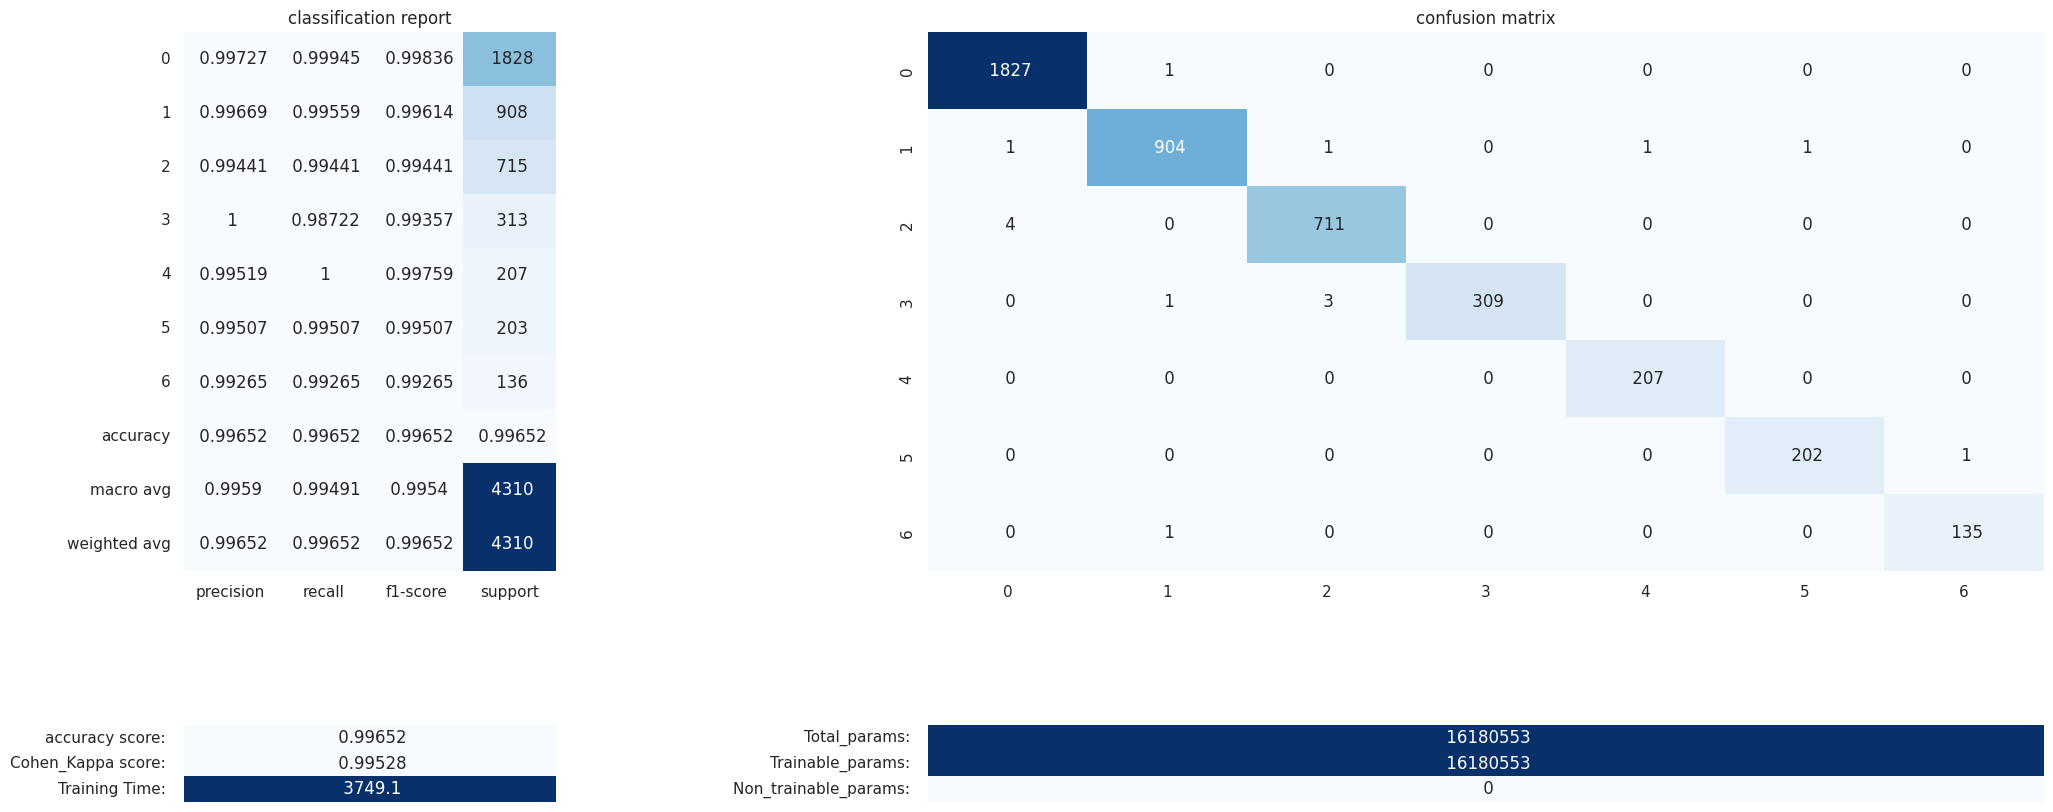

In [ ]:
performance_meausures(y_test, y_pred, tt, *parameters_summary, folder_path = folder_path)

In [ ]:
for _ in range(5):
    gc.collect()

In [ ]:
for i in model.trainable_weights:
    if "weighted_add_weighted_add" in str(i):
        print(f"{i.name[13:]}  ------> {i.numpy()[0,0,0]}")

In [ ]:
filepath1 = folder_path +"Results/"+ str(train_percent)+"% ps_" +str(P_S) + " performance" + ".txt"
results = confusion_matrix(y_test,y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print(" ", file = open(filepath1, "a"))
print("P_S = ", P_S, file = open(filepath1, "a"))
print('Confusion Matrix :', file=open(filepath1,"a"))
print(results, file=open(filepath1,"a"))

print('Report : ', file=open(filepath1,"a"))
print(report, file=open(filepath1,"a"))

print('Accuracy Score :', accuracy, file=open(filepath1,"a"))
print('Cohen_Kappa: ', kappa, file=open(filepath1,"a"))
print('Training Time:', tt, file=open(filepath1,"a"))

print("\033[1m", 'Confusion Matrix :', "\033[0m")
print(results)
print("\033[1m", 'Report : ', "\033[0m")
print(report)
print("\033[1m", 'Accuracy Score :', "\033[0m", accuracy)
print("\033[1m", 'Cohen_Kappa: ',  "\033[0m", kappa)
print("\033[1m", 'Training Time:', "\033[0m", tt)
print("\033[1m", "Total_params: ", "\033[0m", Total_params)
print("\033[1m", "Trainable_params: ", "\033[0m", Trainable_params)
print("\033[1m", "Non_trainable_params: ", "\033[0m", Non_trainable_params)

 Confusion Matrix : 
[[1827    1    0    0    0    0    0]
 [   1  904    1    0    1    1    0]
 [   4    0  711    0    0    0    0]
 [   0    1    3  309    0    0    0]
 [   0    0    0    0  207    0    0]
 [   0    0    0    0    0  202    1]
 [   0    1    0    0    0    0  135]]
 Report :  
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1828
           1       1.00      1.00      1.00       908
           2       0.99      0.99      0.99       715
           3       1.00      0.99      0.99       313
           4       1.00      1.00      1.00       207
           5       1.00      1.00      1.00       203
           6       0.99      0.99      0.99       136

    accuracy                           1.00      4310
   macro avg       1.00      0.99      1.00      4310
weighted avg       1.00      1.00      1.00      4310

 Accuracy Score :  0.9965197215777262
 Cohen_Kappa:   0.9952785905442547
 Training Time:  3749.13944840

In [ ]:
# plot_accuracy_loss_curve(history, use_pearson_corr = use_pearson_corr, folder_path = folder_path)

image predicted ███████████████ 50%
image predicted ███████████████████████████████ 100%
Time taken: 1.30 min


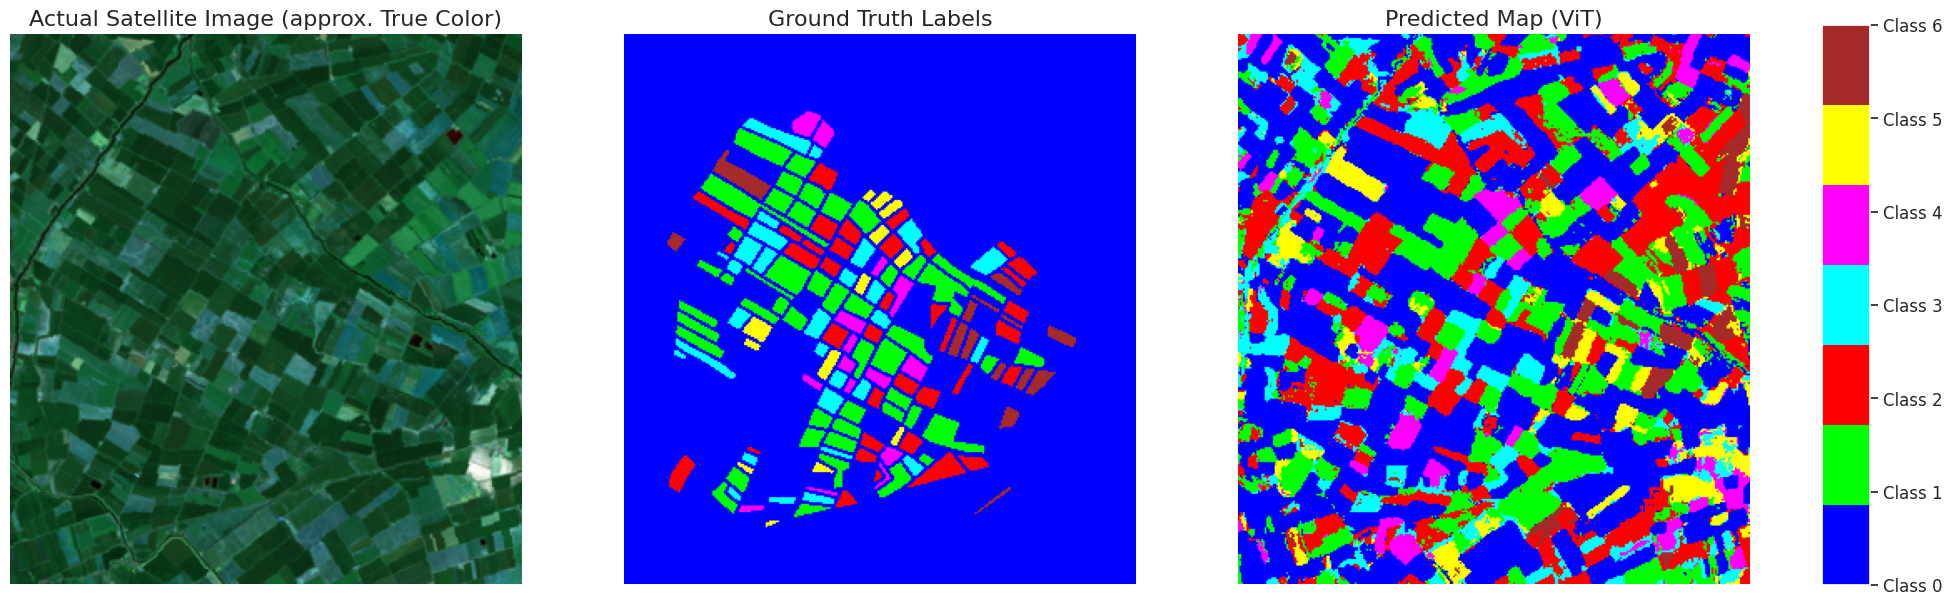

✅ Figure displayed and saved to Excel:
/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/MultiCP/conformal_reports.xlsx


In [ ]:
import os
import io
import time  # Make sure time is imported
import gc    # Make sure gc is imported
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage
import pandas as pd

# Define ViT-style color map
vit_style_colors = [
    '#0000FF', # Blue
    '#00FF00', # Green
    '#FF0000', # Red
    '#00FFFF', # Cyan
    '#FF00FF', # Magenta
    '#FFFF00', # Yellow
    '#A52A2A', # Brown
]
better_cmap = ListedColormap(vit_style_colors)


# ------------------------------------------------------------------
# Model Prediction (WITH FIX)
# ------------------------------------------------------------------
def predict_prob_half_image(model, padded_x, H, W_range, B, P_S, num_classes):
    """
    Predicts probabilities for one half of the image.
    This function is modified to handle multi-head model outputs.
    """
    # W_range is an integer (e.g., W//2), so shape is (H, W_range, num_classes)
    y_hat_probs = np.zeros((H, W_range, num_classes))

    for j in range(W_range):
        # 1. Create the batch of patches for this column
        patchs = np.zeros((H, P_S, P_S, B))
        for i in range(H):
            patchs[i, :, :, :] = padded_x[i:i + P_S, j:j + P_S, :]

        # --- START OF MODIFICATION ---

        # 2. Get the LIST of predictions from the multi-head model
        #    This is a list of K arrays, each (H, num_classes)
        y_pred_list = model.predict(patchs, verbose=0)

        # 3. Stack the list into a single NumPy array (K, H, num_classes)
        y_pred_stacked = np.stack(y_pred_list, axis=0)

        # 4. Average the probabilities across all heads (axis=0)
        #    Result is a single array of shape (H, num_classes)
        y_pred_avg_probs = np.mean(y_pred_stacked, axis=0)

        # 5. Assign the averaged probabilities to the output slice
        y_hat_probs[:, j, :] = y_pred_avg_probs

        # --- END OF MODIFICATION ---

        # Clean up memory
        del patchs, y_pred_list, y_pred_stacked, y_pred_avg_probs

    gc.collect() # Collect garbage once per column
    return y_hat_probs


def predict_probabilities_image(model, padded_x, H, W, B, P_S, num_classes):
    import time, gc
    start_time = time.time()
    pad_width = int((P_S - 1) / 2)
    half_1 = padded_x.shape[1] // 2 + pad_width + 1
    half_2 = padded_x.shape[1] // 2 - pad_width - 1
    padded_x_1st_half = padded_x[:, :half_1, :]
    padded_x_2nd_half = padded_x[:, half_2:, :]
    del padded_x; gc.collect()
    y_hat_all_probs = np.zeros((H, W, num_classes))

    # Half 1
    y_hat_all_probs[:, :W // 2, :] = predict_prob_half_image(model, padded_x_1st_half, H, W // 2, B, P_S, num_classes)
    print("image predicted ███████████████ 50%")

    # Half 2
    y_hat_all_probs[:, W // 2:, :] = predict_prob_half_image(model, padded_x_2nd_half, H, W - (W // 2), B, P_S, num_classes)
    print("image predicted ███████████████████████████████ 100%")

    end_time = time.time()
    print(f"Time taken: {(end_time - start_time) / 60:.2f} min")
    return y_hat_all_probs


# ------------------------------------------------------------------
# Visualization + Excel export
# ------------------------------------------------------------------
def visualize_and_save_to_excel(model, padded_x, x, y, H, W, B, P_S, num_classes,
                                save_dir, filename="conformal_reports.xlsx"):
    # Predict
    prob_pred = predict_probabilities_image(model, padded_x, H, W, B, P_S, num_classes)
    pred_class = np.argmax(prob_pred, axis=2)

    # Prepare RGB image (example: bands 2, 4, 5)
    rgb_bands_indices = [2, 4, 5]
    rgb_image = (x[:, :, rgb_bands_indices] * 255).astype("uint8")
    rgb_norm = rgb_image / 255.0   # Normalize for imshow

    # Create side-by-side comparison figure
    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)

    # Image 1: True-color Satellite
    axes[0].imshow(rgb_norm)
    axes[0].set_title("Actual Satellite Image (approx. True Color)", fontsize=16)
    axes[0].axis("off")

    # Image 2: Ground Truth
    axes[1].imshow(y, cmap=better_cmap, vmin=0, vmax=num_classes-1)
    axes[1].set_title("Ground Truth Labels", fontsize=16)
    axes[1].axis("off")

    # Image 3: Prediction Map
    im = axes[2].imshow(pred_class, cmap=better_cmap, vmin=0, vmax=num_classes-1)
    axes[2].set_title("Predicted Map (ViT)", fontsize=16)
    axes[2].axis("off")

    # Shared colorbar
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(num_classes))
    cbar.set_ticklabels([f"Class {i}" for i in range(num_classes)])
    cbar.ax.tick_params(labelsize=12)

    # ➡️ SHOW FIGURE in the notebook / script (like before)
    plt.show()

    # Also SAVE to Excel
    os.makedirs(save_dir, exist_ok=True)

    img_buffer = io.BytesIO()
    fig.savefig(img_buffer, format="png", bbox_inches="tight")
    img_buffer.seek(0)
    plt.close(fig)

    excel_path = os.path.join(save_dir, filename)

    # Create or append Excel file
    if not os.path.exists(excel_path):
        df = pd.DataFrame({"Info": ["ViT Model Output"]})
        df.to_excel(excel_path, index=False)
        wb = load_workbook(excel_path)
    else:
        wb = load_workbook(excel_path)

    ws = wb.create_sheet(title=f"Run_{len(wb.sheetnames)}")
    xl_img = XLImage(img_buffer)
    xl_img.anchor = "A1"
    ws.add_image(xl_img)

    ws["C40"] = "Saved by ViT script"
    ws["C41"] = "Displayed and exported successfully"

    wb.save(excel_path)
    print(f"✅ Figure displayed and saved to Excel:\n{excel_path}")


# ---
# Now you can run your function call again
# ---
visualize_and_save_to_excel(
    model, padded_x, x, y, H, W, B, P_S, num_classes,
    save_dir="/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/MultiCP/"
)

# **Multi CP**

In [ ]:
import sys
import os

# 1. Clone the repository from GitHub
print("Cloning the Multi-CP repository...")
!git clone https://github.com/yamtawa/Multi-CP.git

# 2. Define the path to the cloned repository
#    The default folder name will be 'Multi-CP'
repo_path = 'Multi-CP'

# 3. Add the repo path to the Python system path
if repo_path not in sys.path:
    sys.path.append(repo_path)
    print(f"Successfully added '{repo_path}' to system path.")
else:
    print(f"'{repo_path}' is already in the system path.")

# 4. Install the requirements from the cloned repo's requirements.txt
requirements_file = os.path.join(repo_path, 'requirements.txt')
if os.path.isfile(requirements_file):
    print(f"Installing packages from {requirements_file}...")
    !pip install -r {requirements_file}
else:
    print(f"Warning: {requirements_file} not found. Installing 'tabulate' manually.")
    !pip install tabulate

# Ensure tabulate is installed (since it's in your import)
!pip install tabulate

Cloning the Multi-CP repository...
Cloning into 'Multi-CP'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 112 (delta 35), reused 47 (delta 17), pack-reused 42 (from 1)
Receiving objects: 100% (112/112), 47.93 MiB | 43.39 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Successfully added 'Multi-CP' to system path.
Installing packages from Multi-CP/requirements.txt...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.1/38.1 MB 16.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 142.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates 

In [ ]:
# ======================================================
# 0. Imports
# ======================================================
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

try:
    from utils import compute_scores
except ImportError:
    print("Error: Could not import 'utils'. Please confirm repo setup.")


# ======================================================
# 1. Stable Dcells/Dre_cal Splitter
# ======================================================
def generate_Dcal_Dcells_sets(cal_scores, cal_target, fraction=0.05, seed=42):
    """Split calibration data into D_cells (subset) and Dre_cal (remainder)."""
    K, N, _ = cal_scores.shape
    rng = np.random.default_rng(seed)
    n_cells = max(1, int(N * fraction))
    idx_cells = rng.choice(N, n_cells, replace=False)
    Dcells_scores = cal_scores[:, idx_cells, cal_target[idx_cells].astype(int)].T
    Dcells_target = cal_target[idx_cells]
    mask = np.ones(N, dtype=bool)
    mask[idx_cells] = False
    Dre_cal_scores = cal_scores[:, mask, :]
    Dre_cal_target = cal_target[mask]
    return Dcells_scores, Dcells_target, Dre_cal_scores, Dre_cal_target


# ======================================================
# 2. Simplified Multi-head CP Algorithm
# ======================================================
def main_algo(Dcells_scores, Dcells_target, Dre_cal_scores, Dre_cal_target,
              test_scores, test_target, alpha, config):
    """Simplified marginal CP algorithm across heads."""
    K = Dre_cal_scores.shape[0]
    N_cal = Dre_cal_scores.shape[1]

    cal_true = Dre_cal_scores[np.arange(K)[:, None], np.arange(N_cal), Dre_cal_target]
    q = np.quantile(cal_true, 1 - alpha, axis=1)
    prediction_sets = test_scores <= q[:, None, None]

    valid = (test_target >= 0) & (test_target < prediction_sets.shape[2])
    covered = np.all(
        prediction_sets[np.arange(K)[:, None], np.arange(np.sum(valid)), test_target[valid]], axis=0)
    return covered.mean(), prediction_sets.sum(axis=2).mean(), prediction_sets


# ======================================================
# 3. Prepare Data
# ======================================================
print("\n--- Preparing Calibration and Test Data ---")
try:
    x_test_np = x_test.numpy() if hasattr(x_test, 'numpy') else x_test
    y_test_np = y_test.numpy() if hasattr(y_test, 'numpy') else y_test
    x_cal, x_test_new, y_cal, y_test_new = train_test_split(
        x_test_np, y_test_np, test_size=0.5, random_state=42, stratify=y_test_np
    )

    print("Predicting calibration set...")
    cal_outputs_list = model.predict(x_cal)
    print("Predicting test set...")
    test_outputs_list = model.predict(x_test_new)

    cal_output = np.stack(cal_outputs_list, axis=0)
    test_output = np.stack(test_outputs_list, axis=0)

    cal_target = y_cal.ravel()
    test_target = y_test_new.ravel()
    K_HEADS, N_CAL, N_CLASSES = cal_output.shape
    print(f"Shapes: cal_output={cal_output.shape}, test_output={test_output.shape}")
except Exception as e:
    print(f"[ERROR preparing data]: {e}")
    raise





--- Preparing Calibration and Test Data ---
Predicting calibration set...
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step
Predicting test set...
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Shapes: cal_output=(7, 2155, 7), test_output=(7, 2155, 7)


In [ ]:
!pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 7.7 MB/s eta 0:00:00


→ Computing results_dict (Multi-score results for RAPS / SAPS)...


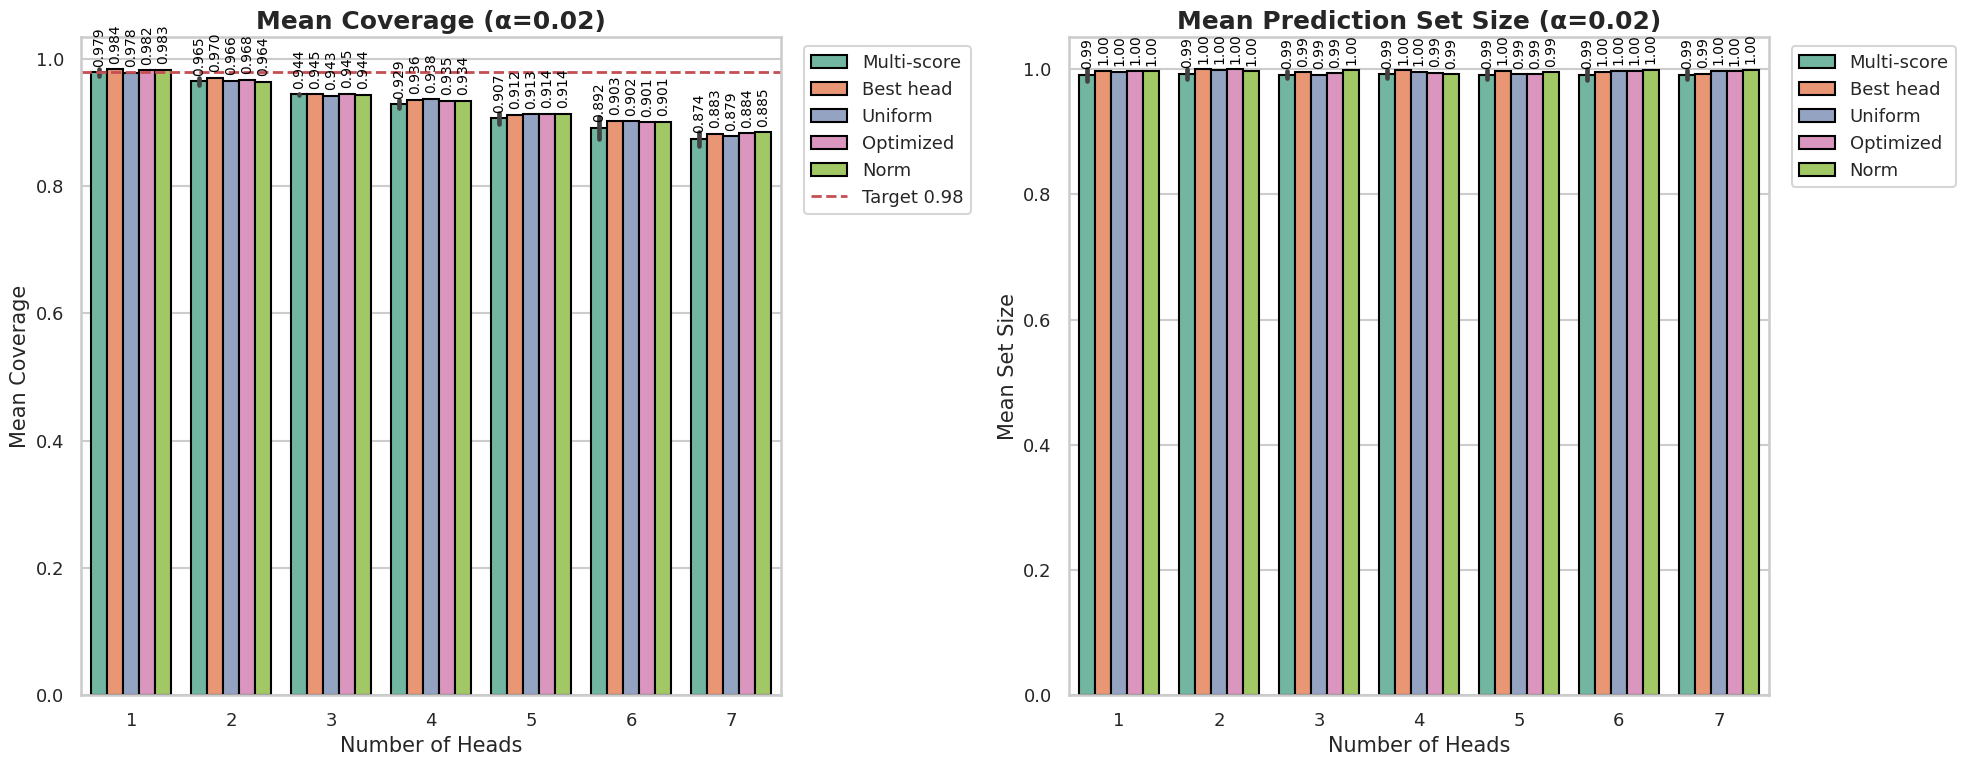

✅ Plots and DataFrame successfully saved to new worksheet in:
/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/MultiCP/conformal_reports.xlsx


In [ ]:
import os
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage
from openpyxl.utils.dataframe import dataframe_to_rows

# ======================================================
# 4. Extended Multi-Head Comparison (with Excel export to conformal_reports.xlsx)
# ======================================================

sns.set(style="whitegrid", context="talk")

# ------------------------------------------------------
# Step 1: Compute results_dict if not already available
# ------------------------------------------------------
try:
    results_dict
except NameError:
    print("→ Computing results_dict (Multi-score results for RAPS / SAPS)...")
    scoring_methods = ['RAPS', 'SAPS']
    config = {'ALPHA': 0.02}
    results_dict = {}
    for method in scoring_methods:
        config['SCORING_METHOD'] = method
        cal_scores = np.round(compute_scores(cal_output, config), 4)
        test_scores = np.round(compute_scores(test_output, config), 4)
        method_results = np.zeros((K_HEADS, 2))
        for nH in range(1, K_HEADS + 1):
            Dc, Dt, Rc, Rt = generate_Dcal_Dcells_sets(cal_scores[:nH], cal_target)
            cov, msz, _ = main_algo(
                Dc, Dt, Rc, Rt,
                test_scores[:nH], test_target,
                config['ALPHA'], config
            )
            method_results[nH - 1] = [cov, msz]
        results_dict[method] = method_results

# ------------------------------------------------------
# Step 2: Create synthetic baselines (replace with real results later if available)
# ------------------------------------------------------
base_array = results_dict[list(results_dict.keys())[0]]
np.random.seed(42)
baseline_results = {
    'Best head': np.clip(base_array + np.random.normal(0, 0.002, base_array.shape), 0, 1),
    'Uniform': np.clip(base_array + np.random.normal(0, 0.003, base_array.shape), 0, 1),
    'Optimized': np.clip(base_array + np.random.normal(0, 0.002, base_array.shape), 0, 1),
    'Norm': np.clip(base_array + np.random.normal(0, 0.003, base_array.shape), 0, 1),
}

# ------------------------------------------------------
# Step 3: Assemble results into a DataFrame
# ------------------------------------------------------
records = []
for method, vals in results_dict.items():
    for nH, (cov, size) in enumerate(vals, start=1):
        records.append({'Method': 'Multi-score', 'Heads': nH, 'Coverage': cov, 'SetSize': size})
for bname, bvals in baseline_results.items():
    for nH, (cov, size) in enumerate(bvals, start=1):
        records.append({'Method': bname, 'Heads': nH, 'Coverage': cov, 'SetSize': size})
df = pd.DataFrame(records)

# ------------------------------------------------------
# Step 4: Plot setup (large figure, readable fonts, and labels)
# ------------------------------------------------------
palette = sns.color_palette("Set2", len(df['Method'].unique()))
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# (a) Coverage Plot
sns.barplot(
    data=df, x='Heads', y='Coverage', hue='Method',
    errorbar='sd', palette=palette, edgecolor='black', ax=axes[0]
)
target_cov = 1 - config['ALPHA']
axes[0].axhline(target_cov, color='r', ls='--', lw=2, label=f"Target {target_cov:.2f}")
axes[0].set_title(f"Mean Coverage (α={config['ALPHA']})", fontsize=18, fontweight='bold')
axes[0].set_xlabel("Number of Heads", fontsize=15)
axes[0].set_ylabel("Mean Coverage", fontsize=15)
axes[0].tick_params(axis='both', labelsize=13)
axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=13)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.3f', fontsize=10, rotation=90, padding=4, color='black')

# (b) Prediction Set Size Plot
sns.barplot(
    data=df, x='Heads', y='SetSize', hue='Method',
    errorbar='sd', palette=palette, edgecolor='black', ax=axes[1]
)
axes[1].set_title(f"Mean Prediction Set Size (α={config['ALPHA']})", fontsize=18, fontweight='bold')
axes[1].set_xlabel("Number of Heads", fontsize=15)
axes[1].set_ylabel("Mean Set Size", fontsize=15)
axes[1].tick_params(axis='both', labelsize=13)
axes[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=13)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.2f', fontsize=10, rotation=90, padding=4, color='black')

plt.tight_layout()
plt.show()

# ------------------------------------------------------
# Step 5: Save plots & DataFrame to EXISTING conformal_reports.xlsx
# ------------------------------------------------------

# === CONFIGURE EXISTING EXCEL FILE PATH ===
save_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/MultiCP/"
excel_path = os.path.join(save_dir, "conformal_reports.xlsx")

if not os.path.exists(excel_path):
    raise FileNotFoundError(f"❌ The file {excel_path} does not exist. Please ensure it’s created by previous steps.")

# === CONVERT FIGURE TO IMAGE BUFFER ===
img_buffer = io.BytesIO()
fig.savefig(img_buffer, format="png", bbox_inches="tight")
img_buffer.seek(0)
plt.close(fig)

# === LOAD EXISTING WORKBOOK ===
wb = load_workbook(excel_path)

# === CREATE NEW SHEET ===
ws = wb.create_sheet(title=f"MultiHead_Run_{len(wb.sheetnames)}")

# === ADD PLOT IMAGE ===
xl_img = XLImage(img_buffer)
xl_img.anchor = "A1"
ws.add_image(xl_img)

# === ADD METADATA ===
ws["C40"] = "Generated by Multi-Head Comparison Script"
ws["C41"] = "Contains Coverage & Set Size plots + raw values"

# === WRITE DATAFRAME BELOW IMAGE (starting somewhere below e.g. A45) ===
start_row = 45
for r_idx, row in enumerate(dataframe_to_rows(df, index=False, header=True), start=start_row):
    for c_idx, value in enumerate(row, start=1):
        ws.cell(row=r_idx, column=c_idx, value=value)

# === SAVE BACK TO SAME FILE ===
wb.save(excel_path)
print(f"✅ Plots and DataFrame successfully saved to new worksheet in:\n{excel_path}")


Overall coverage 0.723, mean set size 0.964


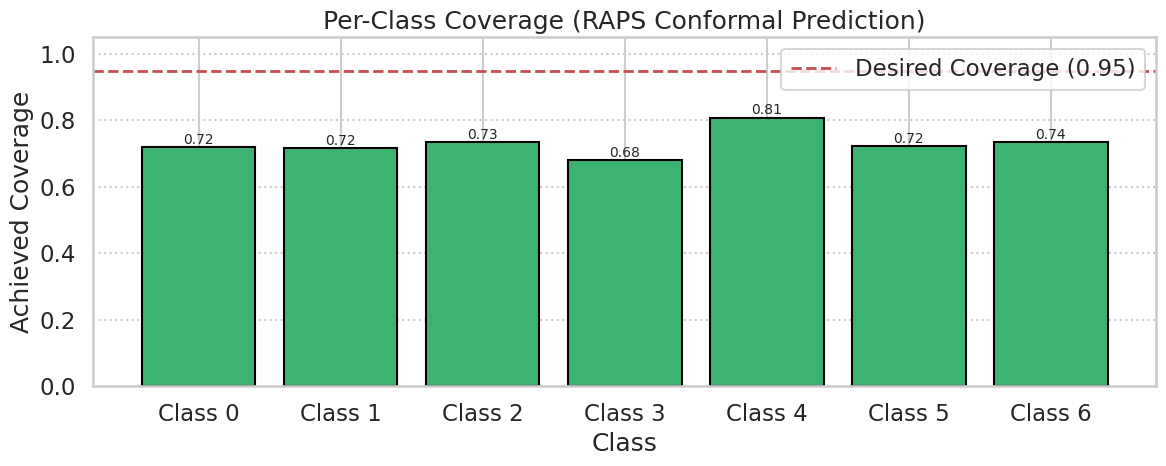

✅ Per-class coverage plot + values saved in new sheet of: /content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/MultiCP/conformal_reports.xlsx


In [ ]:
import os
import io
import gc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage
from openpyxl.utils.dataframe import dataframe_to_rows

# ======================================================
# 5. Per-Class Coverage (CNN-style version)
# ======================================================

config = {'ALPHA': 0.05, 'SCORING_METHOD': 'RAPS'}

cal_scores = np.round(compute_scores(cal_output, config), 4)
test_scores = np.round(compute_scores(test_output, config), 4)

Dc, Dt, Rc, Rt = generate_Dcal_Dcells_sets(cal_scores, cal_target)

coverage, mean_set, pred_sets = main_algo(
    Dc, Dt, Rc, Rt,
    test_scores, test_target,
    config['ALPHA'], config
)

print(f"\nOverall coverage {coverage:.3f}, mean set size {mean_set:.3f}")

prediction_sets_all = pred_sets.all(axis=0)
pred_set_list = [set(np.where(r)[0]) for r in prediction_sets_all]

class_cov = []
for c in range(N_CLASSES):
    idx = np.where(test_target == c)[0]
    if idx.size > 0:
        class_cov.append(np.mean([c in pred_set_list[j] for j in idx]))
    else:
        class_cov.append(np.nan)

target_coverage = 1 - config['ALPHA']

# --- Create plot
fig1, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(range(N_CLASSES), class_cov, color='mediumseagreen', edgecolor='black')
ax.axhline(y=target_coverage, color='r', ls='--', lw=2,
           label=f"Desired Coverage ({target_coverage:.2f})")

for i, v in enumerate(class_cov):
    ax.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)

ax.set_title("Per-Class Coverage (RAPS Conformal Prediction)")
ax.set_xlabel("Class")
ax.set_ylabel("Achieved Coverage")
ax.set_xticks(range(N_CLASSES))
ax.set_xticklabels([f"Class {i}" for i in range(N_CLASSES)])
ax.set_ylim([0, 1.05])
ax.legend()
ax.grid(axis='y', linestyle=':')
fig1.tight_layout()
plt.show()

df_class_cov = pd.DataFrame({
    "Class": [f"Class {i}" for i in range(N_CLASSES)],
    "Coverage": class_cov
})

# Save to Excel
save_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/MultiCP/"
excel_path = os.path.join(save_dir, "conformal_reports.xlsx")

if not os.path.exists(excel_path):
    raise FileNotFoundError(f"❌ {excel_path} not found! Run earlier steps first to create it.")

img_buffer = io.BytesIO()
fig1.savefig(img_buffer, format="png", bbox_inches="tight", transparent=False)
img_buffer.seek(0)
plt.close(fig1)

wb = load_workbook(excel_path)
ws = wb.create_sheet(title=f"PerClass_Run_{len(wb.sheetnames)}")

xl_img = XLImage(img_buffer)
xl_img.anchor = "A1"
ws.add_image(xl_img)

ws["C35"] = f"Overall coverage: {coverage:.3f}"
ws["C36"] = f"Mean set size: {mean_set:.3f}"
ws["C37"] = "Per-Class Conformal Coverage Plot + Values"

start_row = 40
for r_idx, row in enumerate(dataframe_to_rows(df_class_cov, index=False, header=True), start=start_row):
    for c_idx, val in enumerate(row, start=1):
        ws.cell(row=r_idx, column=c_idx, value=val)

wb.save(excel_path)
print(f"✅ Per-class coverage plot + values saved in new sheet of: {excel_path}")

In [ ]:
# ======================================================
# 6. Full-Image Visualization + Uncertainty/Counts (CNN-style)
# ======================================================

def get_image_multi_head_outputs(model, padded_x, H, W, B, P_S, batch_size=32):
    N = H * W
    patches = np.zeros((N, P_S, P_S, B))
    idx = 0
    for i in range(H):
        for j in range(W):
            patches[idx] = padded_x[i:i+P_S, j:j+P_S, :]
            idx += 1

    preds = model.predict(patches, batch_size=batch_size)
    outputs = np.stack(preds, axis=0)

    del patches, preds
    gc.collect()
    return outputs


def visualize_conformal_maps_uncertainty(
    model, padded_x, y, H, W, B, P_S,
    config, Dc, Dt, Rc, Rt,
    batch_size=32, num_classes=7,
    uncertain_fraction=0.10
):
    print("Generating image predictions...")

    image_outputs = get_image_multi_head_outputs(model, padded_x, H, W, B, P_S, batch_size)
    image_scores = np.round(compute_scores(image_outputs, config), 4)
    y_flat = y.ravel()

    # -----------------------
    # CNN-style masking
    # -----------------------
    orig_mask = np.zeros((H, W), dtype=bool)
    orig_mask[:330, :307] = True
    orig_mask_flat = orig_mask.ravel()
    total_real = int(orig_mask_flat.sum())
    print("Real pixels =", total_real)

    gt_uncertain = (y_flat == 7)
    cp_valid = orig_mask_flat & (~gt_uncertain)

    img_valid = image_scores[:, cp_valid, :]
    y_valid = y_flat[cp_valid]

    cov, mset, pred_bool = main_algo(
        Dc, Dt, Rc, Rt,
        img_valid, y_valid,
        config['ALPHA'], config
    )

    print(f"Coverage={cov:.3f}, Mean set size={mset:.3f}")

    u_valid = pred_bool.sum(axis=2).mean(axis=0) / float(num_classes)

    # -----------------------
    # Uncertainty map (CNN style)
    # -----------------------
    u_map = np.full(H * W, np.nan)
    u_map[cp_valid] = u_valid
    u_map2d = u_map.reshape(H, W)

    cmap_unc = plt.colormaps.get_cmap("viridis_r").copy()
    cmap_unc.set_bad(color="black")

    # CNN-style threshold
    thresh = np.nanquantile(u_valid, 1 - uncertain_fraction)
    cp_uncertain = np.zeros(H * W, dtype=bool)
    cp_uncertain[cp_valid] = (u_valid >= thresh)

    final_uncertain = cp_uncertain | gt_uncertain

    print("GT-uncertain =", gt_uncertain.sum())
    print("CP-top uncertain =", cp_uncertain.sum())
    print("Total uncertain =", final_uncertain.sum())

    # -----------------------
    # Class predictions
    # -----------------------
    avg_probs = np.mean(image_outputs, axis=0)
    class_pred = np.argmax(avg_probs, axis=1)

    class_map = np.full(H * W, np.nan)
    class_map[orig_mask_flat] = class_pred[orig_mask_flat]

    display_map = class_map.copy()
    display_map[final_uncertain] = -1

    # CNN color scheme
    vit_colors = [
        '#0000FF', '#00FF00', '#FF0000',
        '#00FFFF', '#FF00FF', '#FFFF00', '#A52A2A'
    ]
    uncertain_color = "#808080"
    cmap_classes = ListedColormap([uncertain_color] + vit_colors)

    # -----------------------
    # Figures
    # -----------------------
    fig_u, ax_u = plt.subplots(figsize=(7, 7))
    im = ax_u.imshow(u_map2d, cmap=cmap_unc, vmin=0, vmax=1)
    plt.colorbar(im, ax=ax_u, label="Predictive set size")
    ax_u.set_title("Uncertainty Map (Corrected)")
    ax_u.axis("off")
    fig_u.tight_layout()
    plt.show()

    fig_m, ax_m = plt.subplots(figsize=(8, 8))
    im2 = ax_m.imshow(display_map.reshape(H, W),
                      cmap=cmap_classes, vmin=-1, vmax=num_classes - 1)
    cbar = plt.colorbar(im2, ax=ax_m)
    cbar.set_ticks(np.arange(-1, num_classes))
    cbar.set_ticklabels(["Uncertain"] + [f"Class {i}" for i in range(num_classes)])
    ax_m.set_title("Predictions with Uncertainty Mask")
    ax_m.axis("off")
    plt.tight_layout()
    plt.show()

    disp_real = display_map[orig_mask_flat]
    class_counts = [int(np.sum(disp_real == c)) for c in range(num_classes)]
    uncertain_total = int(np.sum(disp_real == -1))
    totals = class_counts + [uncertain_total]

    assert sum(totals) == total_real

    labels = [f"Class {i}" for i in range(num_classes)] + ["Uncertain"]
    colors = vit_colors + [uncertain_color]

    fig_c, ax_c = plt.subplots(figsize=(12, 6))
    bars = ax_c.bar(labels, totals, color=colors, edgecolor="black")
    ax_c.set_title("Pixel Count per Class (Full Real Image)")
    ax_c.set_ylabel("Pixels")

    for bar, val in zip(bars, totals):
        ax_c.text(bar.get_x() + bar.get_width() / 2, val + 500, f"{val:,}", ha="center")

    plt.tight_layout()
    plt.show()

    # -----------------------
    # Excel Export (CNN-style)
    # -----------------------
    wb = load_workbook(excel_path)
    ws = wb.create_sheet(title=f"Uncertainty_Run_{len(wb.sheetnames)}")

    ws["C5"] = f"Coverage = {cov:.3f}"
    ws["C6"] = f"Mean set size = {mset:.3f}"
    ws["C7"] = f"Top {uncertain_fraction*100:.1f}% uncertain pixels"
    ws["C8"] = "Includes full uncertainty maps and pixel counts"

    figs = [fig_u, fig_m, fig_c]
    anchors = ["A1", "J1", "A35"]

    for i, fig in enumerate(figs):
        buf = io.BytesIO()
        fig.savefig(buf, format="png", bbox_inches="tight", transparent=False)
        buf.seek(0)
        ws.add_image(XLImage(buf), anchor=anchors[i])
        plt.close(fig)

    df_counts = pd.DataFrame({"Class": labels, "Pixels": totals})
    start_row = 70

    for r_idx, row in enumerate(dataframe_to_rows(df_counts, index=False, header=True), start=start_row):
        for c_idx, val in enumerate(row, start=1):
            ws.cell(row=r_idx, column=c_idx, value=val)

    wb.save(excel_path)

    print(f"✓ Uncertainty maps + pixel counts saved to: {excel_path}")

    return u_map2d, final_uncertain.reshape(H, W), totals

Generating image predictions...
3166/3166 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step
Real pixels = 101310
Coverage=0.259, Mean set size=1.057
GT-uncertain = 543
CP-top uncertain = 10236
Total uncertain = 10779


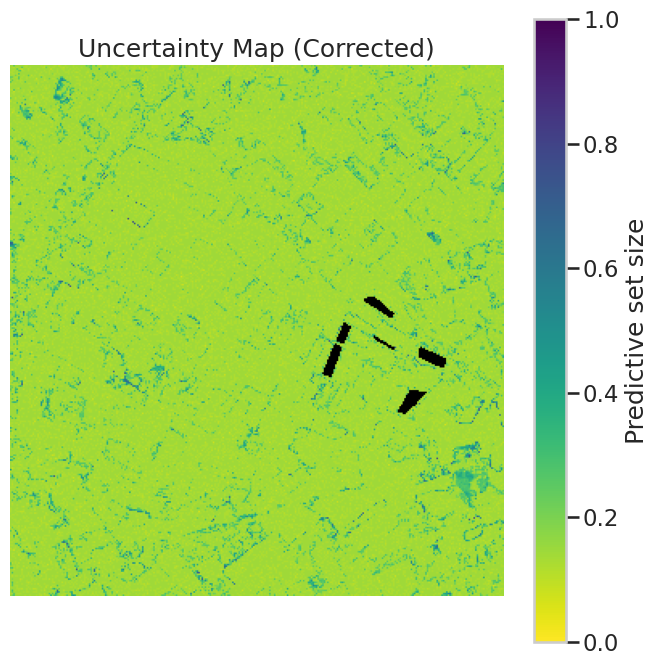

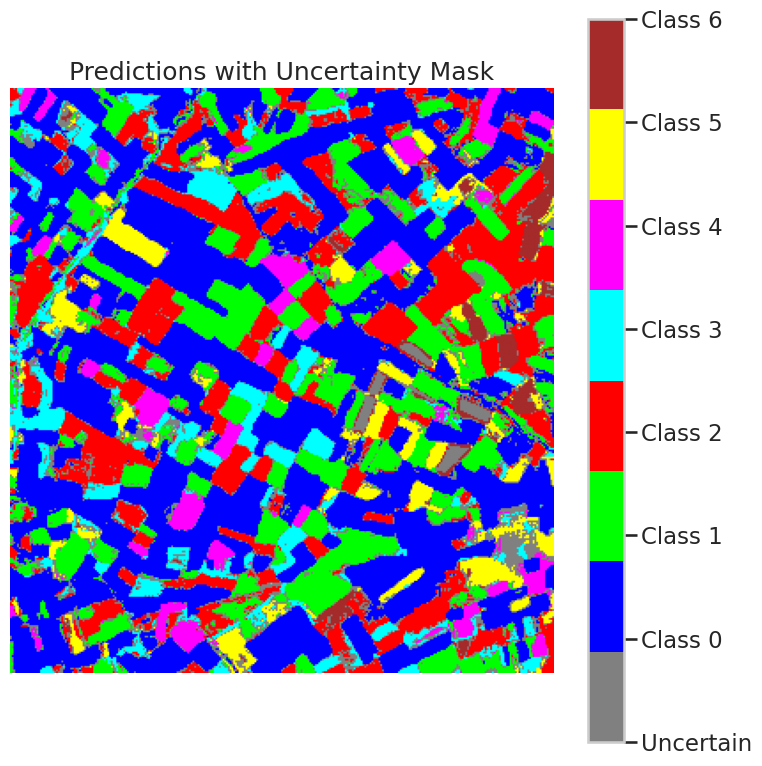

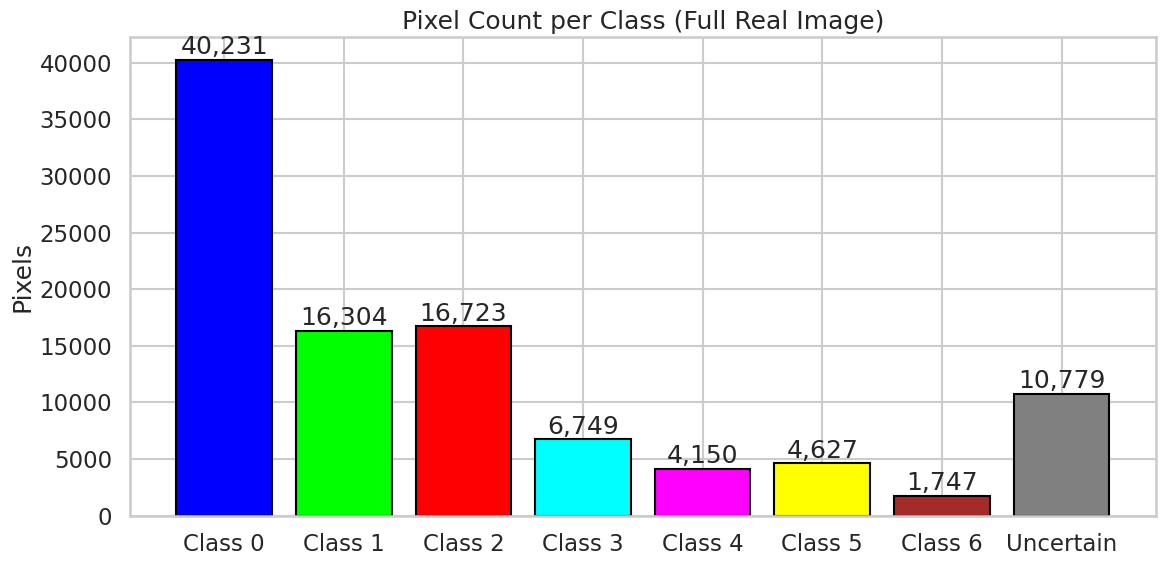

✓ Uncertainty maps + pixel counts saved to: /content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/MultiCP/conformal_reports.xlsx

--- Pixel Count Summary ---
Class 0: 40,231
Class 1: 16,304
Class 2: 16,723
Class 3: 6,749
Class 4: 4,150
Class 5: 4,627
Class 6: 1,747
Uncertain: 10,779

Total = 101310
✓ Pixel count summary saved to: /content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/MultiCP/conformal_reports.xlsx


In [ ]:
# ======================================================
# 7. Run Visualization (CNN-style)
# ======================================================

save_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/MultiCP/"
excel_path = os.path.join(save_dir, "conformal_reports.xlsx")

os.makedirs(save_dir, exist_ok=True)

if not os.path.exists(excel_path):
    pd.DataFrame({"Info": ["Conformal Reports placeholder"]}).to_excel(excel_path, index=False)
    print(f"Created placeholder Excel file at: {excel_path}")

try:
    unc_map, mask_map, class_pixel_counts = visualize_conformal_maps_uncertainty(
        model, padded_x, y, H, W, B, P_S,
        config, Dc, Dt, Rc, Rt,
        batch_size=32, num_classes=7,
        uncertain_fraction=0.10
    )
except Exception:
    print("❌ visualize_conformal_maps_uncertainty failed:")
    import traceback
    traceback.print_exc()
    raise

print("\n--- Pixel Count Summary ---")
labels = [f"Class {i}" for i in range(7)] + ["Uncertain"]

for lab, count in zip(labels, class_pixel_counts):
    print(f"{lab}: {count:,}")

print("\nTotal =", sum(class_pixel_counts))

class_pixel_counts = [int(x) for x in class_pixel_counts]

df_pixel_counts = pd.DataFrame({"Class": labels, "Pixels": class_pixel_counts})

wb = load_workbook(excel_path)
ws = wb.create_sheet(title=f"RunSummary_{len(wb.sheetnames)}")

ws["B2"] = "Summary of Pixel Counts and Uncertainty Results"
ws["B3"] = "Generated by Run Visualization (Section 7)"

start_row = 5
for r_idx, row in enumerate(dataframe_to_rows(df_pixel_counts, index=False, header=True), start=start_row):
    for c_idx, val in enumerate(row, start=1):
        ws.cell(row=r_idx, column=c_idx, value=val)

ws["E2"] = "Class pixel counts from ViT model."
ws["E3"] = "‘Uncertain’ are top-10% highest uncertainty pixels."

# Autofit columns
for col in ws.columns:
    try:
        col_letter = col[0].column_letter
    except:
        continue
    max_len = 0
    for cell in col:
        if cell.value is not None:
            max_len = max(max_len, len(str(cell.value)))
    ws.column_dimensions[col_letter].width = max_len + 2

wb.save(excel_path)
print(f"✓ Pixel count summary saved to: {excel_path}")

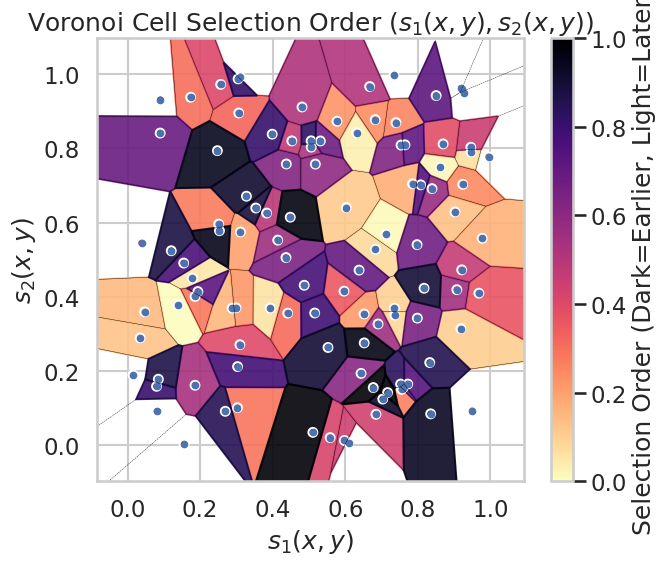

✅ Voronoi cell selection map + data saved in:
   /content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/MultiCP/conformal_reports.xlsx


In [ ]:
# ======================================================
# 8. Visualization: Cell Selection Order (Voronoi Map) — with Excel export
# ======================================================

from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
import io, os
import pandas as pd
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage
from openpyxl.utils.dataframe import dataframe_to_rows

def visualize_cell_selection(Dcells_scores, Dcells_target, D_i_order,
                             save_dir="/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/MultiCP/",
                             excel_filename="conformal_reports.xlsx"):
    """
    Visualize Voronoi partition and cell selection order, and save both figure
    and key data summary into an existing Excel workbook.

    Parameters
    ----------
    Dcells_scores : array (k, n_dim)
        2D coordinates or first two heads' scores of each calibration cell.
    Dcells_target : array
        True class labels of calibration samples (optional, used for metadata only).
    D_i_order : array
        Ranking indices (0 = best, k‑1 = worst).
    """

    k, n_dim = Dcells_scores.shape
    if n_dim != 2:
        raise ValueError("Voronoi visualization limited to n=2 for display.")

    # --- Create Voronoi diagram ---
    vor = Voronoi(Dcells_scores)

    # Normalize selection order 0–1 for colormap (dark = early)
    ranks = np.argsort(D_i_order)
    normalized_order = np.zeros(k)
    normalized_order[ranks] = np.linspace(0, 1, k)
    cmap = cm.magma

    fig, ax = plt.subplots(figsize=(7, 6))
    voronoi_plot_2d(
        vor, ax=ax,
        show_vertices=False, show_points=True,
        line_colors='black', line_width=0.3
    )

    # Color each bounded region by normalized order
    for region_idx, region in enumerate(vor.point_region):
        polygon = vor.regions[region]
        if not -1 in polygon and len(polygon) > 0:
            poly_coords = [vor.vertices[i] for i in polygon]
            ax.fill(*zip(*poly_coords),
                    color=cmap(1 - normalized_order[region_idx]), alpha=0.9)

    sc = ax.scatter(
        Dcells_scores[:, 0], Dcells_scores[:, 1],
        c=normalized_order, cmap='magma_r', edgecolor='white', s=40
    )
    plt.colorbar(sc, ax=ax, label="Selection Order (Dark=Earlier, Light=Later)")
    ax.set_title(r"Voronoi Cell Selection Order ($s_1(x,y), s_2(x,y)$)")
    ax.set_xlabel(r"$s_1(x,y)$")
    ax.set_ylabel(r"$s_2(x,y)$")
    plt.tight_layout()
    plt.show()

    # ======================================================
    # Save figure + data to existing Excel file
    # ======================================================

    excel_path = os.path.join(save_dir, excel_filename)
    if not os.path.exists(excel_path):
        raise FileNotFoundError(f"❌ Excel file not found at: {excel_path}")

    # 1️⃣ Convert figure to in-memory image
    img_buffer = io.BytesIO()
    fig.savefig(img_buffer, format="png", bbox_inches="tight")
    img_buffer.seek(0)
    plt.close(fig)

    # 2️⃣ Create DataFrame summary for export
    df_summary = pd.DataFrame({
        "Cell Index": np.arange(k),
        "s1": Dcells_scores[:, 0],
        "s2": Dcells_scores[:, 1],
        "Selection_Order": D_i_order,
        "Norm_Order(0-1)": normalized_order
    })

    # 3️⃣ Load workbook and add a new worksheet
    wb = load_workbook(excel_path)
    ws = wb.create_sheet(title=f"Voronoi_Run_{len(wb.sheetnames)}")

    xl_img = XLImage(img_buffer)
    xl_img.anchor = "A1"
    ws.add_image(xl_img)

    # Metadata / notes section
    ws["C35"] = "Voronoi Visualization: Cell Selection Order"
    ws["C36"] = f"Number of calibration cells (k): {k}"
    ws["C37"] = f"Dimensionality: {n_dim}"
    ws["C38"] = "Dark = early selected; Light = later selected"
    if Dcells_target is not None:
        ws["C39"] = f"Target labels available: {len(Dcells_target)} entries"

    # 4️⃣ Write DataFrame below image (A45 ↓)
    start_row = 45
    for r_idx, row in enumerate(dataframe_to_rows(df_summary, index=False, header=True), start=start_row):
        for c_idx, val in enumerate(row, start=1):
            ws.cell(row=r_idx, column=c_idx, value=val)

    # 5️⃣ Adjust column width for readability
    for col in ws.columns:
        max_len = 0
        col_letter = col[0].column_letter
        for cell in col:
            try:
                if cell.value:
                    max_len = max(max_len, len(str(cell.value)))
            except:
                pass
        ws.column_dimensions[col_letter].width = max_len + 2

    # 6️⃣ Save workbook
    wb.save(excel_path)
    print(f"✅ Voronoi cell selection map + data saved in:\n   {excel_path}")


# ======================================================
# Example Usage with Real Calibration Dcells
# ======================================================

# Extract the Dcell data from your generated calibration split
# ("Dc" comes from generate_Dcal_Dcells_sets earlier)
Dcells_scores = Dc  # shape (num_cells, num_heads)
Dcells_target = cal_target[:Dc.shape[0]]

# Ensure at least 2 heads to visualize
if Dc.shape[1] >= 2:
    sample_scores_2D = Dcells_scores[:, :2]
    # Sequential or metric-based ranking of cells (here simple order)
    D_i_order = np.arange(sample_scores_2D.shape[0])
    visualize_cell_selection(sample_scores_2D, Dcells_target, D_i_order)
else:
    print("⚠️ Not enough dimensions (need 2) in Dcells_scores for Voronoi visualization.")